In [495]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install numpy
%pip install scikit-learn
%pip install calmap
%pip install streamlit
%pip install plotly
%pip install nbformat>=4.2.0
%pip install category_encoders
%pip install statsmodels
%pip install wordcloud


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [496]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import glob
import os
import datetime
import requests
import re
import time
import sys
import spotipy
import spotipy.oauth2 as oauth2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import stats
from scipy.stats import pearsonr
import calmap
import streamlit as st
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import iplot
from plotly.graph_objs import Scatter, Layout
import statsmodels.api as sm
from pprint import pprint
from wordcloud import WordCloud
import textwrap

In [497]:
df=pd.read_csv('combined.csv')

C:\Users\14014\AppData\Local\Temp\ipykernel_14000\4059180406.py:1: DtypeWarning:

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.



In [498]:
df.shape

(120378, 21)

In [499]:
df.columns

Index(['ts', 'username', 'platform', 'ms_played', 'conn_country',
       'ip_addr_decrypted', 'user_agent_decrypted',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'reason_start',
       'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp',
       'incognito_mode'],
      dtype='object')

In [500]:
df.drop(['username', 'offline', 'offline_timestamp', 'incognito_mode', 'conn_country', 'ip_addr_decrypted', 'user_agent_decrypted'], axis=1, inplace=True) 

In [501]:
df.rename(columns={'ts': 'timestamp', 'master_metadata_track_name': 'track_name', 'master_metadata_album_artist_name': 'artist_name','master_metadata_album_album_name': 'album_name'}, inplace=True)

In [502]:
print(df.dtypes)

timestamp              object
platform               object
ms_played               int64
track_name             object
artist_name            object
album_name             object
spotify_track_uri      object
episode_name           object
episode_show_name      object
spotify_episode_uri    object
reason_start           object
reason_end             object
shuffle                  bool
skipped                object
dtype: object


In [503]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [504]:
df['timestamp_et'] = df['timestamp'].dt.tz_convert('US/Eastern')

In [505]:
df['date'] = df['timestamp_et'].dt.date
df['time'] = df['timestamp_et'].dt.time

In [506]:
df.rename(columns={'date': 'date_listened', 'time': 'time_listened'}, inplace=True)

In [507]:
df['seconds'] = df['ms_played'] / 1000

In [508]:
df = df.fillna('')

In [509]:
df.drop(['timestamp'], axis=1, inplace=True)

In [510]:
df.drop(['platform'], axis=1, inplace=True)

In [511]:
df.rename(columns={'episode_name': 'episode_title', 'episode_show_name': 'podcast_name', 'seconds':'seconds_played'}, inplace=True)

In [512]:
df = df.convert_dtypes()

In [513]:
df['year'] = df['timestamp_et'].dt.year
df['month'] = df['timestamp_et'].dt.month
df['day_num'] = df['timestamp_et'].dt.day
df['day_of_week'] = df['timestamp_et'].dt.dayofweek
df['hour_of_day'] = df['timestamp_et'].dt.hour
df['hours_played'] = df['seconds_played'] / 3600

In [514]:
df['hour_of_day'].count()
df['part_of_day'] = pd.cut(df['hour_of_day'], bins=[-1, 4, 8, 11, 16, 20, 23], labels=['overnight', 'morning', 'late morning', 'afternoon', 'early evening', 'late evening'])

In [515]:
def get_season(date, hemisphere='Northern'):
    month = date.month
    day = date.day

    if hemisphere == 'Northern':
        if (month == 3 and day >= 20) or (4 <= month <= 5) or (month == 6 and day < 21):
            return 'Spring'
        elif (month == 6 and day >= 21) or (7 <= month <= 8) or (month == 9 and day < 22):
            return 'Summer'
        elif (month == 9 and day >= 22) or (10 <= month <= 11) or (month == 12 and day < 21):
            return 'Autumn'
        else:
            return 'Winter'

df['season'] = df['timestamp_et'].apply(lambda x: get_season(x))

In [516]:
def get_month(date):
    month=date.month
    
    if month==1: return 'January'
    if month==2: return 'February'
    if month==3: return 'March'
    if month==4: return 'April'
    if month==5: return 'May'
    if month==6: return 'June'
    if month==7: return 'July'
    if month==8: return 'August'
    if month==9: return 'September'
    if month==10: return 'October'
    if month==11: return 'November'
    if month==12: return 'December'
    
df['month_name'] = df['timestamp_et'].apply(lambda x: get_month(x))

In [517]:
day_of_week_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['day_name'] = df['day_of_week'].map(day_of_week_mapping)

In [518]:
df.rename(columns={'month': 'month_num'}, inplace=True)

In [519]:
df['skipped'] = df['skipped'].apply(lambda x: True if x in [1, 1.0] else False if x in [0, 0.0] else None)
df['skipped'].value_counts()

skipped
True     11175
False     9671
Name: count, dtype: int64

In [520]:
df.columns

Index(['ms_played', 'track_name', 'artist_name', 'album_name',
       'spotify_track_uri', 'episode_title', 'podcast_name',
       'spotify_episode_uri', 'reason_start', 'reason_end', 'shuffle',
       'skipped', 'timestamp_et', 'date_listened', 'time_listened',
       'seconds_played', 'year', 'month_num', 'day_num', 'day_of_week',
       'hour_of_day', 'hours_played', 'part_of_day', 'season', 'month_name',
       'day_name'],
      dtype='object')

In [521]:
df = df.convert_dtypes()

In [522]:
df.dtypes

ms_played                                   Int64
track_name                         string[python]
artist_name                        string[python]
album_name                         string[python]
spotify_track_uri                  string[python]
episode_title                      string[python]
podcast_name                       string[python]
spotify_episode_uri                string[python]
reason_start                       string[python]
reason_end                         string[python]
shuffle                                   boolean
skipped                                   boolean
timestamp_et           datetime64[ns, US/Eastern]
date_listened                              object
time_listened                              object
seconds_played                            Float64
year                                        Int32
month_num                                   Int32
day_num                                     Int32
day_of_week                                 Int32


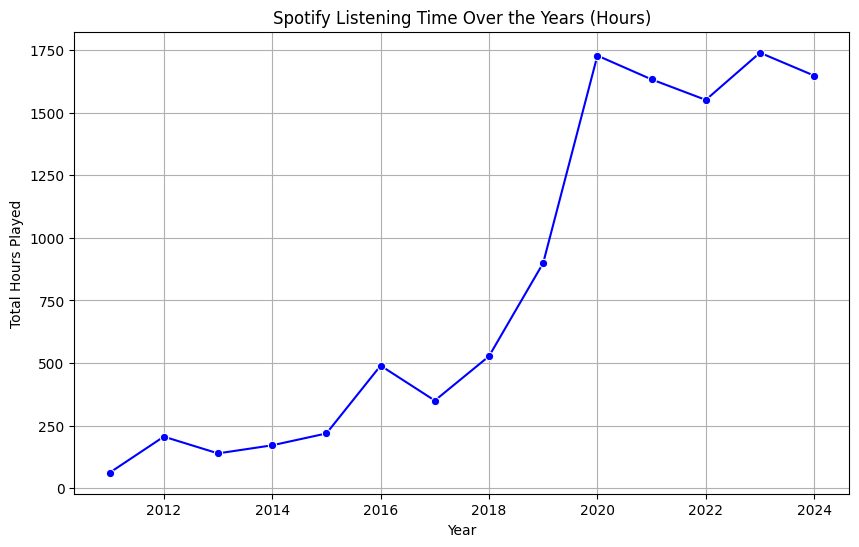

In [523]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='year', y='hours_played', estimator='sum', errorbar=None, marker='o', color='blue')
plt.xlabel('Year')
plt.ylabel('Total Hours Played')
plt.title('Spotify Listening Time Over the Years (Hours)')
plt.grid(True)
plt.show()

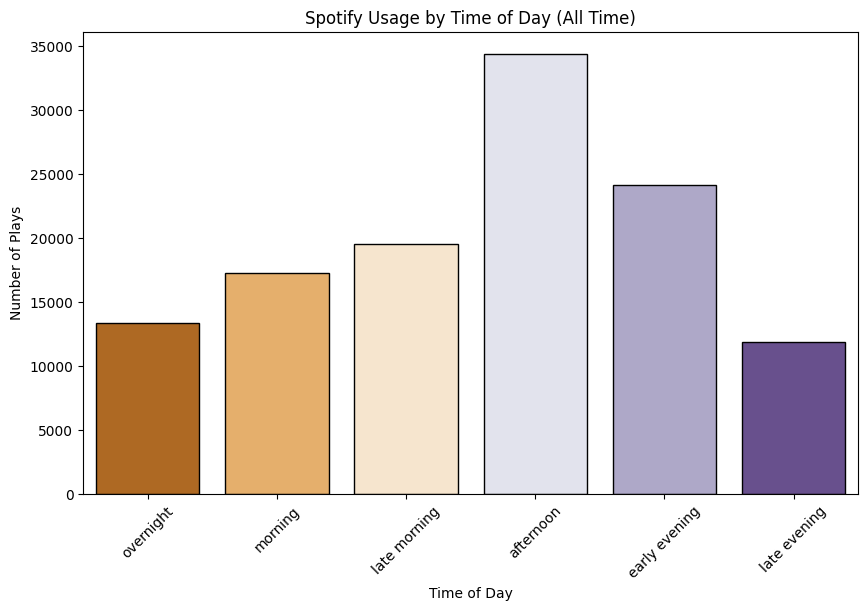

In [524]:
plt.figure(figsize=(10,6))
sns.countplot(x='part_of_day', data=df, edgecolor='black', hue='part_of_day', palette='PuOr')
plt.xticks(rotation=45)
plt.xlabel('Time of Day')
plt.ylabel('Number of Plays')
plt.title('Spotify Usage by Time of Day (All Time)')
plt.show()

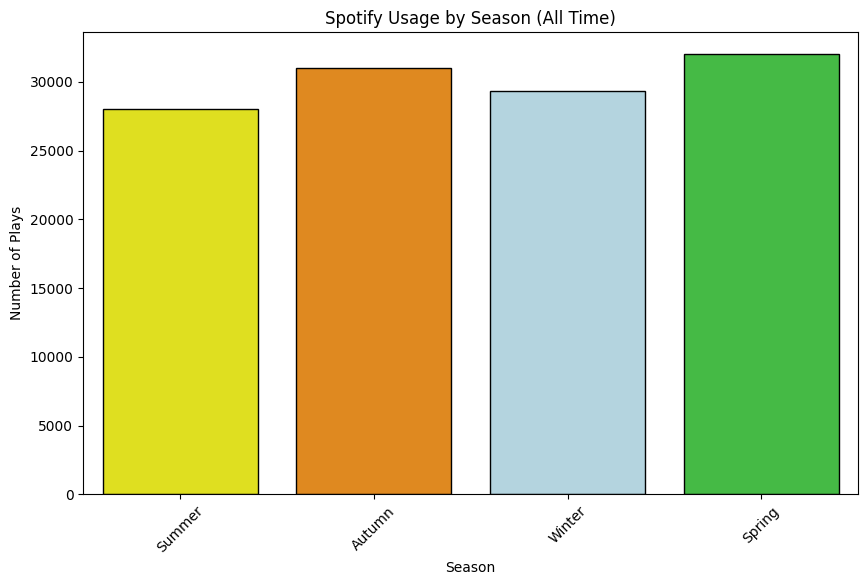

In [525]:
set_palette = {'Spring': 'limegreen', 'Summer': 'yellow', 'Autumn': 'darkorange', 'Winter': 'lightblue'}
plt.figure(figsize=(10,6))
sns.countplot(x='season', data=df, hue='season', palette=set_palette, edgecolor='black')
plt.xticks(rotation=45)
plt.xlabel('Season')
plt.ylabel('Number of Plays')
plt.title('Spotify Usage by Season (All Time)')
plt.show()

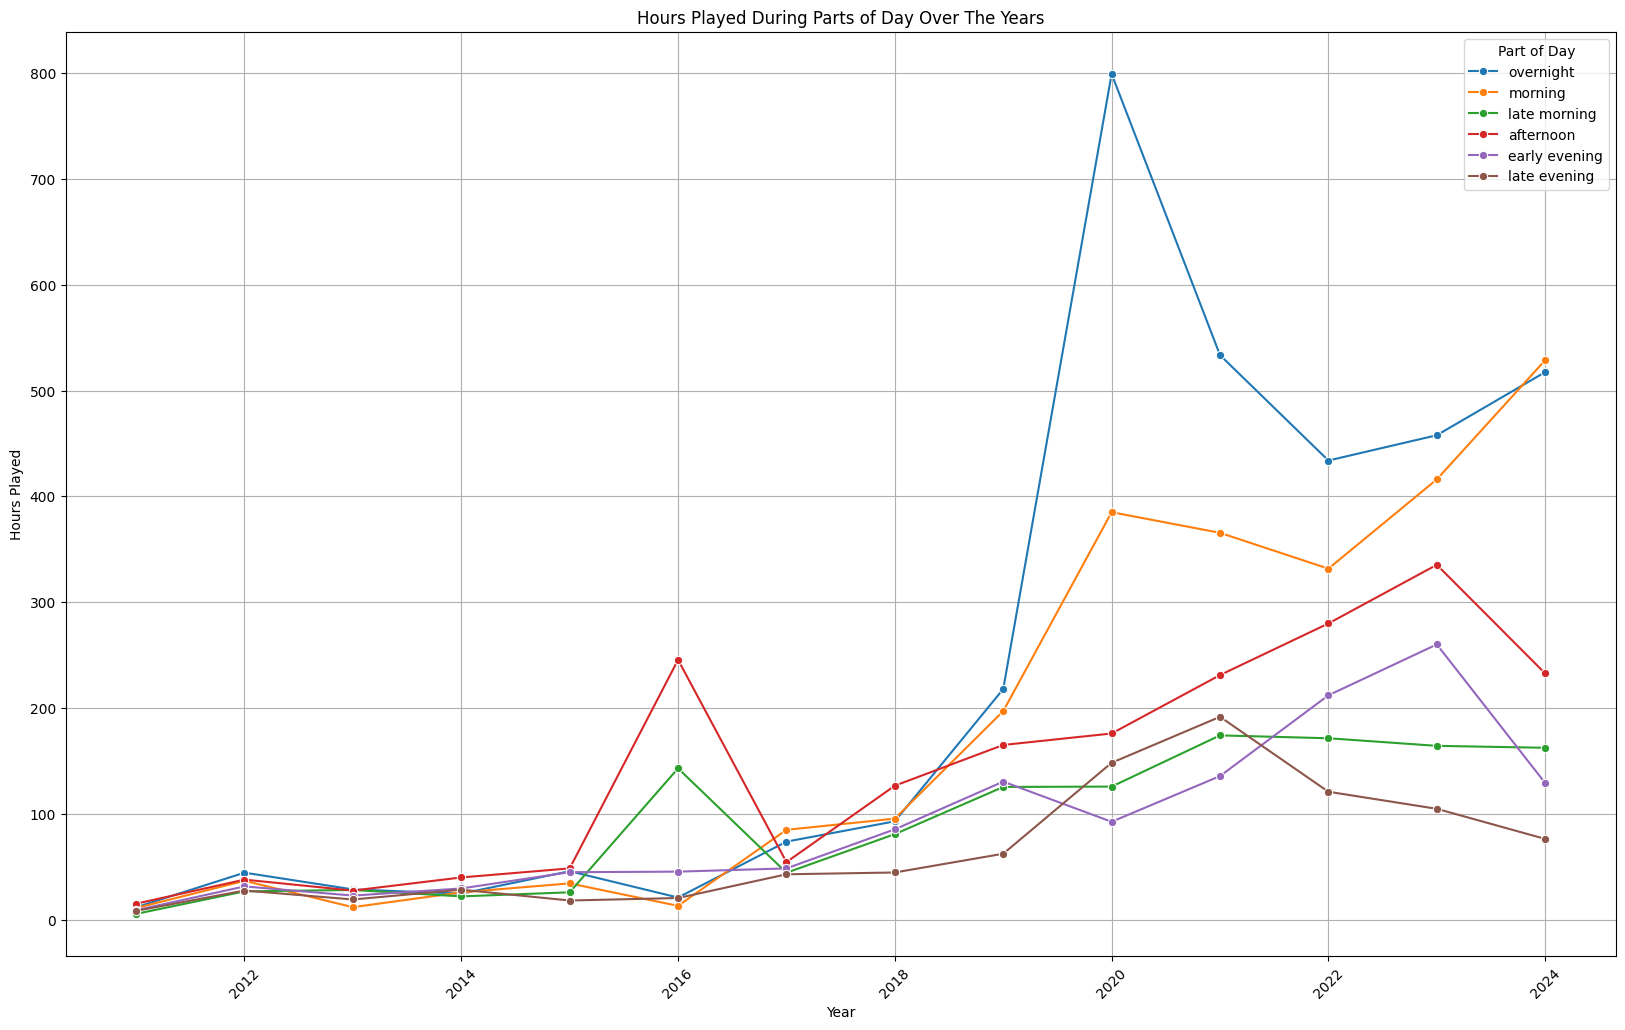

In [526]:
plt.figure(figsize=(20, 12))
plt.grid(True)
sns.lineplot(data=df, x='year', y='hours_played', estimator='sum', marker='o', hue='part_of_day', errorbar=None)
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Hours Played')
plt.title('Hours Played During Parts of Day Over The Years') 
plt.legend(title='Part of Day')
plt.show()

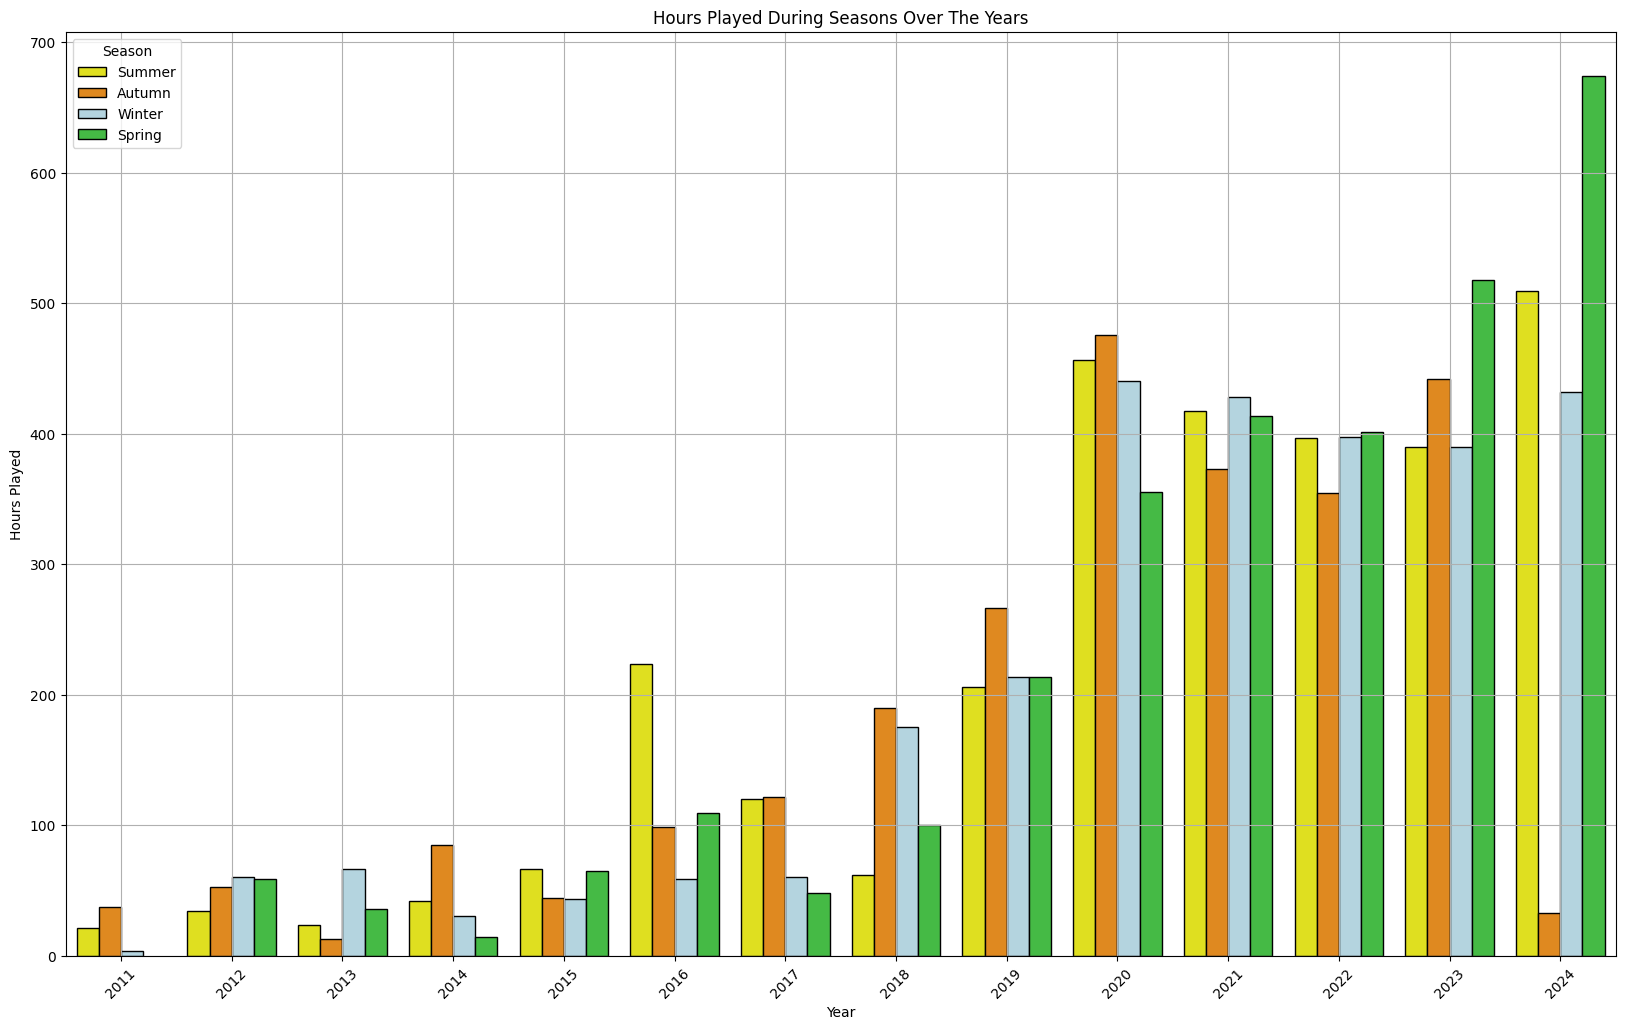

In [527]:
set_palette = {'Spring': 'limegreen', 'Summer': 'yellow', 'Autumn': 'darkorange', 'Winter': 'lightblue'}
plt.figure(figsize=(20, 12))
sns.barplot(x='year', y='hours_played', estimator='sum', hue='season', data=df, palette=set_palette, errorbar=None, edgecolor='black')
plt.grid(True)
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Hours Played')
plt.title('Hours Played During Seasons Over The Years')
plt.legend(title='Season')
plt.show()

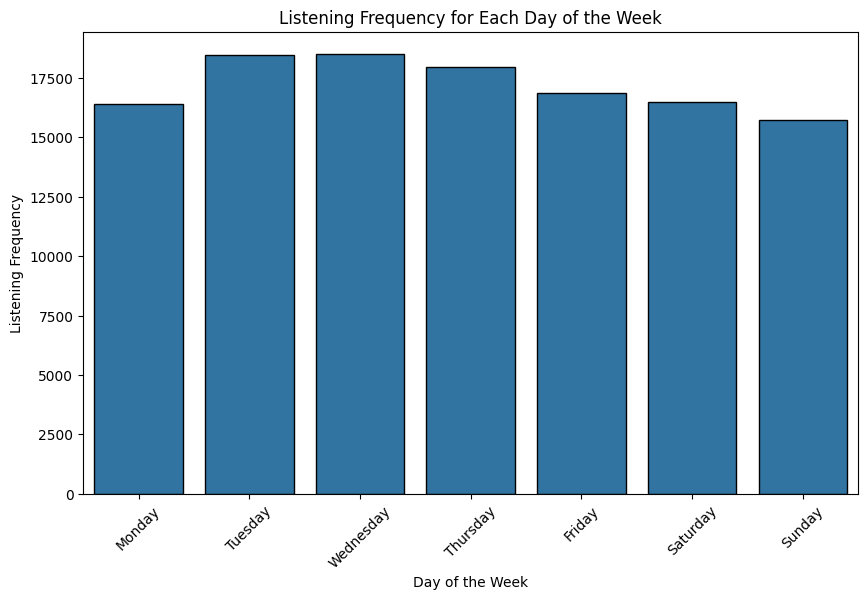

In [528]:
day_of_week_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['day_name'] = df['day_of_week'].map(day_of_week_mapping)
plt.figure(figsize=(10,6))
sns.countplot(x='day_name', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], edgecolor='black')   
plt.xlabel('Day of the Week')
plt.ylabel('Listening Frequency')
plt.title('Listening Frequency for Each Day of the Week')
plt.xticks(rotation=45)
plt.show()

In [529]:
date_range = (df['date_listened'].min(), df['date_listened'].max())
print(f"Date range of data: {date_range[0]} to {date_range[1]}")

Date range of data: 2011-07-17 to 2024-09-26


In [530]:
df['genre'] = ''

#artist genres
df.loc[df['artist_name'] == 'Taylor Swift', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Lana Del Rey', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Miley Cyrus', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Dua Lipa', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Journey', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Halsey', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Selena Gomez', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Alessia Cara', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Troye Sivan', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Tove Lo', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Lauv', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Zara Larsson', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Khalid', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Sam Smith', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Shawn Mendes', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Ed Sheeran', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Harry Styles', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Niall Horan', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'One Direction', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Dream Theater', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Dream', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'TLC', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Destiny\'s Child', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'En Vogue', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Toni Braxton', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Whitney Houston', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Mariah Carey', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Janet Jackson', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Brandy', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Monica', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Aaliyah', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Mary J. Blige', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Celine Dion', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Celeste', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Alicia Keys', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Lianne La Havas', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Jorja Smith', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Sade', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Erykah Badu', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'India.Arie', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Jill Scott', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Solange', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Olivia Rodrigo', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Olivier Messiaen', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Olivia Dean', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Olivia Ong', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Frank Ocean', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Frank Sinatra', 'genre'] = 'Jazz'
df.loc[df['artist_name'] == 'Renée Fleming', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Renée Elise Goldsberry', 'genre'] = 'Musical'
df.loc[df['artist_name'] == 'Kristin Chenoweth', 'genre'] = 'Musical'
df.loc[df['artist_name'] == 'Idina Menzel', 'genre'] = 'Musical'
df.loc[df['artist_name'] == 'Audra McDonald', 'genre'] = 'Musical'
df.loc[df['artist_name'] == 'Sutton Foster', 'genre'] = 'Musical'
df.loc[df['artist_name'] == 'Laura Benanti', 'genre'] = 'Musical'
df.loc[df['artist_name'] == 'Kelli O\'Hara', 'genre'] = 'Musical'
df.loc[df['artist_name'] == 'Lea Salonga', 'genre'] = 'Musical'
df.loc[df['artist_name'] == 'Patti LuPone', 'genre'] = 'Musical'
df.loc[df['artist_name'] == 'Bernadette Peters', 'genre'] = 'Musical'
df.loc[df['artist_name'] == 'Justin Bieber', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Ariana Grande', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Camila Cabello', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Lorde', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Beyoncé', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Adele', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Kacey Musgraves', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Kendrick Lamar', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Drake', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Ariana Grande', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Billie Eilish', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Lady Gaga', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Rihanna', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Katy Perry', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Alicia Keys', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'SZA', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Janelle Monáe', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Solange', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Mitski', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'St. Vincent', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Lizzo', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Lizzy McAlpine', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Maggie Rogers', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Mitski', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Phoebe Bridgers', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'HAIM', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Marina Piccinini', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Carol Wincenc', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Joshua Bell', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Emmanuel Pahud', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'James Galway', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Yo-Yo Ma', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Itzhak Perlman', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Carly Rae Jepsen', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Gracie Abrams', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Novo Amor', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Imogen Heap', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'The Civil Wars', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Birdy', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Billy Joel', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Elton John', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Bruce Springsteen', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Journey', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Radiohead', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Coldplay', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'The War On Drugs', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Blink-182', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Chvrches', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Britney Spears', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Christina Aguilera', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Jessica Simpson', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Mariah Carey', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Shakira', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Enya', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Mandy Moore', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Nelly Furtado', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Norah Jones', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Jessica Simpson', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Norah Jones', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Sara Bareilles', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Sia', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Tori Amos', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Vanessa Carlton', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Michelle Branch', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Dixie Chicks', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Sheryl Crow', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Alanis Morissette', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Jewel', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Shania Twain', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Faith Hill', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'LeAnn Rimes', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Martina McBride', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Trisha Yearwood', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Reba McEntire', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Dolly Parton', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'The Japanese House', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Suki Waterhouse', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Sabrina Carpenter', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Abby Sage', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Lennon Stella', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'LÉON', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Julien Baker', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Phoebe Bridgers', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Mitski', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Japanese Breakfast', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Snail Mail', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Lucy Dacus', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Soccer Mommy', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Clairo', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Beabadoobee', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Del Water Gap', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Leon Bridges', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Royel Otis', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Daniel Caesar', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'H.E.R.', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Yumi Zouma', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Caroline Polachek', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Tiny Habits', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'ROLE MODEL', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Jacob Collier', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Rex Orange County', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Omar Apollo', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'St. Vincent', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Arlo Parks', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Raveena', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Father John Misty', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Olivia Barton', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Wet', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'SYML', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Holly Humberstone', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Hozier', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Cigarettes After Sex', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Childish Gambino', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'ZAYN', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Joni Mitchell', 'genre'] = 'Folk'
df.loc[df['artist_name'] == 'Noah Kahan', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Noah Cyrus', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'EXES', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Matthew and the Atlas', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Family of the Year', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Meadowlark', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'David Guetta', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Calvin Harris', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Kygo', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Avicii', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Zedd', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Martin Garrix', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Marshmello', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Dry the River', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Georges Bizet', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Gioachino Rossini', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Gustavo Dudamel', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Gustavo Mahler', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Gustav Holst', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Leonard Bernstein', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Imani Winds', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Elle King', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Grace Potter', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Brandi Carlile', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Noah Gunderson', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'The Weepies', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Glen Hansard', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Marketa Irglova', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Capital Cities', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Foster The People', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Gary Lightbody', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'James Bay', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Kodaline', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Matchbox Twenty', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'OneRepublic', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Air Review', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Bootstraps', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'BANNERS', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Bastille', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Ben Howard', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Ben Rector', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Benjamin Scheuer', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Birdtalker', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Band of Horses', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Louis C.K.', 'genre'] = 'Comedy'
df.loc[df['artist_name'] == 'Christopher Rouse', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'John Adams', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Sharon Bezaly', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Jake Heggie', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'John Corigliano', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Lisa Garner Santa', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Laurel Zucker', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Jeanne Baxtresser', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Jean-Pierre Rampal', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Matt Nathanson', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Maurice Emmanuel', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Mike Mower', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Meghan Trainor', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Maroon 5', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Mumford & Sons', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Of Monsters and Men', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Marvin Gaye', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Otis Redding', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Sam Cooke', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'The Temptations', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'The Supremes', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'The Song Confessional', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Shakey Graves', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Penny and Sparrow', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'The Oh Hellos', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Morningsiders', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Dermot Kennedy', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'James Vincent McMorrow', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'The La\'s', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Ellie Goulding', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Ellie Holcomb', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'P!nk', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Pink Floyd', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Pink', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'S. Carey', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Sara Watkins', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'The Tallest Man On Earth', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'MisterWives', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Vance Joy', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Jade Bird', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'JP Cooper', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Eric Whitacre', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'North Texas Wind Symphony', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'The King\'s Singers', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'JOSEPH', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'St. Lucia', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'David Guetta', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Robin Thicke', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Fetty Wap', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'San Fermin', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Post Malone', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Foy Vance', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Henry Jamison', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Wrabel', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'The Moth & The Flame', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Moth and The Flame', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'A R I Z O N A', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'ARIZONA', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Siv Jakobsen', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Trippie Reed', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Tom Waits', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Susie Suh', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Noah Reid', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Mark Ronson', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'llsey', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Robin Schulz', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Klingande', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Kygo', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Lost Frequencies', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Felix Jaehn', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Sam Feldt', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Bakermat', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Kungs', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Jonas Blue', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Sigala', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Jonas Brothers', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Conan Gray', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Conan O\'Brien', 'genre'] = 'Comedy'
df.loc[df['artist_name'] == 'Dagny', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'LANY', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Rusted Root', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Lewis Capaldi', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'The National Parks', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Stephen Sanchez', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Kate Bush', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Dominic Fike', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Tears For Fears', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Coldplay', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Cold War Kids', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Tame Impala', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Joji', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Artic Monkeys', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Cage The Elephant', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'OneRepublic', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Dessa', 'genre'] = 'Hip-Hop'  
df.loc[df['artist_name'] == 'Cannons', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Rynn', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Emmit Fenn', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Bazzi', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Alesso', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Ava Max', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Zara Larsson', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Anne-Marie', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Dua Lipa', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Sophie Ellis-Bextor', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Kylie Minogue', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Sophie Holohan', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'THE ANXIETY', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Kehlani', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Jhené Aiko', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'WILLOW', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Tyler Cole', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Kiana Ledé', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Abby Sage', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Abby Gunderson', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Alexi Murdoch', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Alec Benjamin', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Alessia Cara', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Alex & Sierra', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Alex G', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Alex Lahey', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Alex Turner', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Ben Kessler', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Ben Platt', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Ben Rector', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Benjamin Francis Leftwich', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Kelsea Ballerini', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'The Staves', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'The Four Tops', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Semisonic', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Third Eye Blind', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Vertical Horizon', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The Wallflowers', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The Verve Pipe', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Paul Simon', 'genre'] = 'Folk'
df.loc[df['artist_name'] == 'Simon & Garfunkel', 'genre'] = 'Folk'
df.loc[df['artist_name'] == 'Cat Stevens', 'genre'] = 'Folk'
df.loc[df['artist_name'] == 'James Taylor', 'genre'] = 'Folk'
df.loc[df['artist_name'] == 'Earth, Wind & Fire', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Radical Face', 'genre'] = 'Indie Folk' 
df.loc[df['artist_name'] == 'Mazzy Star', 'genre'] = 'Indie Rock'  
df.loc[df['artist_name'] == 'Kindness', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Edward Elgar', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Damien Rice', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'A Day To Remember', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The All-American Rejects', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The Red Jumpsuit Apparatus', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Jasmine Thompson', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Lady A', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Lady Antebellum', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Carrie Underwood', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Miranda Lambert', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Little Big Town', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Sugarland', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'The Band Perry', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'The Temper Trap', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Regina Spektor', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Doves', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Feist', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Wolfmother', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Mumm-Ra', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The Kooks', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Fratellis', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'She & Him', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'JP Saxe', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Charlotte Lawrence', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'King Princess', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Sleeping At Last', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Blanco White', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'David Gray', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Lucy Rose', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Lucy Spraggan', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'WALK THE MOON', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Busted', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The Vamps', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'First Aid Kit', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'City and Colour', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Future of Forestry', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Phosphorescent', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Liang Lawrence', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Dustin Tebbutt', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'The Likes of Us', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Perrin Lamb', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Brandon Flowers', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'KALEO', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Roo Panes', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Aziz Ansari', 'genre'] = 'Comedy'
df.loc[df['artist_name'] == 'Kathleen Madigan', 'genre'] = 'Comedy'
df.loc[df['artist_name'] == 'Grace Mitchell', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Maria Callas', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Tyler Childers', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Liz Lawrence', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Alexi Murdoch', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Allman Brown', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Haux', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'James Arthur', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Andrew Belle', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Brad Paisley', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Chris Stapleton', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Eric Church', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Jason Aldean', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Kenny Chesney', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Luke Bryan', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Tim McGraw', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Zac Brown Band', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Zach Bryan', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Valley', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Freya Ridings', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Brendon Urie', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Panic! At The Disco', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Melissa McMillan', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Clean Bandit', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Caamp', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Milo Greene', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Wild Child', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Houndmouth', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Head and the Heart', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Sting', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'The Police', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Stevie Wonder', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'Josh Woodward', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Arcade Fire', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Joker\'s Daughter', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Karen O and the Kids', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Barcelona', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Gotye', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'M83', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Naked and Famous', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Phillip Phillips', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Edwin McCain', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Five for Fighting', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Carolina Liar', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Daughter', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Snow Patrol', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Youngblood Hawke', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Young the Giant', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Keane', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Best Coast', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Paquito D\'Rivera', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Phoenix', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Damien Jurado', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Coby Grant', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'WILD', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'ortoPilot', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Will Dailey', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Mal Bloom', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Bad Bad Hats', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Bright Eyes', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Gabe Dixon', 'genre'] = 'Pop'  
df.loc[df['artist_name'] == 'I Am Not Lefthanded', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'T.I.', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Lil Wayne', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Sixpence None The Richer', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'The Cranberries', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The Cardigans', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'The Sundays', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Smashing Pumpkins', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The Verve', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The Stone Roses', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Muse', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Tommy LeFroy', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Wallows', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Neighbourhood', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Jaguar Sun', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'GROUPLOVE', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Manchester Orchestra', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Beck', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Black Keys', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'John Vincent III', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Wombats', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Remi Wolf', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'MUNA', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Ethel Cain', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'girl in red', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Regrettes', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Aces', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'G Flip', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Tegan and Sara', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Naked and Famous', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'FIGHTMASTER', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Sylvan Esso', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Beach House', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Beach Fossils', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Alvvays', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Radio Dept.', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Smiths', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Cure', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Charli XCX', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Tracy Chapman', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Bon Iver', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'The National', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Vampire Weekend', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Gregory Alan Isakov', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Sufjan Stevens', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Kanye West', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Frank Ocean', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'The Strokes', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Fleet Foxes', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'The Shins', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Postal Service', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Death Cab for Cutie', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The xx', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Magnetic Fields', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'New Ceremony', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Beatles', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'Fleetwood Mac', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The 1975', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'The Head And The Heart', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'The Lumineers', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Mumford & Sons', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'The Avett Brothers', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Julia Michaels', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Margaret Cho', 'genre'] = 'Comedy'
df.loc[df['artist_name'] == 'Mat Kearney', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Big Red Machine', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Maurice Ravel', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Giacomo Puccini', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Johann Sebastian Bach', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Florence + The Machine', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Dan + Shay', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Maren Morris', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'The Chicks', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'The Band CAMINO', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'The Wombats', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Gregory Alan Isakov', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'The Paper Kites', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Greg Laswell', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Chappell Roan', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'The Oh Hellos', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Dermot Kennedy', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'The Killers', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Decemberists', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'The Goo Goo Dolls', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The Fratellis', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The All-American Rejects', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'My Chemical Romance', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The Fray', 'genre'] = 'Rock'
df.loc[df['artist_name'] == 'The Script', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'The Chainsmokers', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'American Football', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Laufey', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'John Mayer', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'John Legend', 'genre'] = 'R&B'
df.loc[df['artist_name'] == 'John Mulaney', 'genre'] = 'Comedy'
df.loc[df['artist_name'] == 'Amy Schumer', 'genre'] = 'Comedy'
df.loc[df['artist_name'] == 'The Band CAMINO', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'The Wombats', 'genre'] = 'Indie Rock'
df.loc[df['artist_name'] == 'Iron & Wine', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Christina Jennings', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Ludwig van Beethoven', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Wolfgang Amadeus Mozart', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Antonín Dvořák', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Johannes Brahms', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Frédéric Chopin', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Claude Debussy', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Maurice Ravel', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Franz Schubert', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Robert Schumann', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Franz Liszt', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Sergei Rachmaninoff', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Pyotr Ilyich Tchaikovsky', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Gustav Mahler', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Anton Bruckner', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Giacomo Puccini', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Giuseppe Verdi', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Richard Wagner', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Richard Strauss', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Igor Stravinsky', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Béla Bartók', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Dmitri Shostakovich', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Aaron Copland', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'John Williams', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Philip Glass', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'John Phillip Sousa', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Antonio Vivaldi', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Johann Strauss II', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Gustav Holst', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Edward Elgar', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Jean Sibelius', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Carl Nielsen', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Jean Sibelius', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Henri Dutilleux', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Gabriel Fauré', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Cher', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Demi Lovato', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'The Weeknd', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Kesha', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Katy Perry', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Lady Gaga', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Justin Vernon', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Aaron Dessner', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Bryce Dessner', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Blind Pilot', 'genre'] = 'Indie Folk'
df.loc[df['artist_name'] == 'Bleachers', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Ingrid Michaelson', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Sarah McLachlan', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Stevie Nicks', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Lin-Manuel Miranda', 'genre'] = 'Musical'
df.loc[df['artist_name'] == 'Andrew Lloyd Webber', 'genre'] = 'Musical'
df.loc[df['artist_name'] == 'Stephen Sondheim', 'genre'] = 'Musical'
df.loc[df['artist_name'] == 'Justin Timberlake', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Brad Paisley', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Kanye West', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Kendrick Lamar', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Drake', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Jay-Z', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Eminem', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Nicki Minaj', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Cardi B', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Lil Nas X', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Lil Wayne', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Lil Baby', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Lil Yachty', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Lil Pump', 'genre'] = 'Hip-Hop'
df.loc[df['artist_name'] == 'Carl Vine', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'Eli Young Band', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'György Ligeti', 'genre'] = 'Classical'
df.loc[df['artist_name'] == 'niceboy ed', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Louis C.K.', 'genre'] = 'Comedy'
df.loc[df['artist_name'] == 'Patty Griffin', 'genre'] = 'Country'
df.loc[df['artist_name'] == 'Emmit Fenn', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Rynn', 'genre'] = 'Pop'
df.loc[df['artist_name'] == 'Ellen DeGeneres', 'genre'] = 'Comedy'
df.loc[df['artist_name'].str.contains('Miles Davis', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('John Coltrane', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Duke Ellington', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Louis Armstrong', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Charlie Parker', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Thelonious Monk', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Billie Holiday', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Ella Fitzgerald', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Nina Simone', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Dave Brubeck', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Chet Baker', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Stan Getz', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Sonny Rollins', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Cannonball Adderley', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Herbie Hancock', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('Wayne Shorter', case=False, na=False), 'genre'] = 'Jazz'
df.loc[df['artist_name'].str.contains('John McLaughlin', case=False, na=False), 'genre'] = 'Jazz'

#track name genres
df.loc[df['track_name'] == 'Mad World', 'genre'] = 'Pop'
df.loc[df['track_name'] == 'The Night We Met', 'genre'] = 'Indie Folk'
df.loc[df['track_name'] == 'o magnum mysterium', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'O Magnum Mysterium', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'The Funeral', 'genre'] = 'Indie Rock'
df.loc[df['track_name'] == 'I will not be sad in this world', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'William Tell Overture', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'I Will Wait', 'genre'] = 'Indie Folk'
df.loc[df['track_name'] == 'Starlight', 'genre'] = 'Indie Rock'
df.loc[df['track_name'] == 'Le merle noir', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'Fantaisie', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'Sonata For Flute And Piano: I: Fast', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'Sonata For Flute And Piano: Iii: Very Fast', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'Lincolnshire Posy - Rufford Park Poachers', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'Sonata appasionata in F-Sharp Minor, Op. 140', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'Brahms: Symphony No. 4 in E Minor, Op. 98: IV. Allegro energico e passionato', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'Suite Modale', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'Dutilleux: Sonatine for Flute and Piano: I. Allegro', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'Canzone for Flute and Piano, Op. 38: I', 'genre'] = 'Classical'
df.loc[df['track_name'] == 'Home', 'genre'] = 'Indie Folk'
df.loc[df['track_name'] == 'Hero', 'genre'] = 'Pop'
df.loc[df['track_name'] == 'Fast Car', 'genre'] = 'Pop'
df.loc[df['track_name'].str.contains('Symphony', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Concerto', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Sonata', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Prelude', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Nocturne', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Etude', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Fantasia', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Rhapsody', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Overture', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Serenade', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Intermezzo', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Impromptu', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Capriccio', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Bagatelle', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Ballade', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Mazurka', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Polonaise', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Nocturne', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Waltz', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Violin', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Cello', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Flute', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Trumpet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Horn', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Trombone', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Air Force Band', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Marine Band', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Navy Band', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Army Band', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Quartet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Quintet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Sextet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Septet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Octet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Nonet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Chamber', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Orchestra', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Solo', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Duet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['track_name'].str.contains('Lofi', case=False, na=False), 'genre'] = 'Lo-Fi'
df.loc[df['track_name'].str.contains('Lo-Fi', case=False, na=False), 'genre'] = 'Lo-Fi'
df.loc[df['track_name'].str.contains('Lo Fi', case=False, na=False), 'genre'] = 'Lo-Fi'
df.loc[df['track_name'].str.contains('Lo-fi', case=False, na=False), 'genre'] = 'Lo-Fi'
df.loc[df['track_name'].str.contains('Green Noise', case=False, na=False), 'genre'] = 'Soundscape'
df.loc[df['track_name'].str.contains('White Noise', case=False, na=False), 'genre'] = 'Soundscape'
df.loc[df['track_name'].str.contains('Pink Noise', case=False, na=False), 'genre'] = 'Soundscape'
df.loc[df['track_name'].str.contains('Brown Noise', case=False, na=False), 'genre'] = 'Soundscape'

#album name genres
df.loc[df['album_name'].str.contains('Symphony', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Symphony', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Concerto', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Sonata', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Prelude', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Nocturne', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Etude', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Fantasia', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Rhapsody', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Overture', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Serenade', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Intermezzo', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Impromptu', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Capriccio', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Bagatelle', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Ballade', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Mazurka', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Polonaise', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Nocturne', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Waltz', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Violin', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Cello', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Flute', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Trumpet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Horn', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Trombone', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Air Force Band', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Marine Band', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Navy Band', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Army Band', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Quartet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Quintet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Sextet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Septet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Octet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Nonet', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Chamber', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Orchestra', case=False, na=False), 'genre'] = 'Classical'
df.loc[df['album_name'].str.contains('Lo-Fi', case=False, na=False), 'genre'] = 'Lo-Fi'
df.loc[df['album_name'].str.contains('Lofi', case=False, na=False), 'genre'] = 'Lo-Fi'
df.loc[df['album_name'].str.contains('Lo Fi', case=False, na=False), 'genre'] = 'Lo-Fi'
df.loc[df['album_name'].str.contains('Wicked', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('Hamilton', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('Les Misérables', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('Phantom of the Opera', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('Cats', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('Mamma Mia', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('The Sound of Music', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('Grease', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('West Side Story', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('Chicago', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('Rent', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('A Chorus Line', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('Hairspray', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('The Book of Mormon', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('Dear Evan Hansen', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('Waitress', case=False, na=False), 'genre'] = 'Musical'
df.loc[df['album_name'].str.contains('Soundtrack', case=False, na=False), 'genre'] = 'Movie Soundtrack'
df.loc[df['album_name'].str.contains('Green Noise', case=False, na=False), 'genre'] = 'Soundscape'
df.loc[df['album_name'].str.contains('White Noise', case=False, na=False), 'genre'] = 'Soundscape'
df.loc[df['album_name'].str.contains('Pink Noise', case=False, na=False), 'genre'] = 'Soundscape'
df.loc[df['album_name'].str.contains('Brown Noise', case=False, na=False), 'genre'] = 'Soundscape'


#podcast name genres
df.loc[df['podcast_name'] == 'Armchair Expert with Dax Shepard', 'genre'] = 'Comedy Podcast'
df.loc[df['podcast_name'] == 'Amy Schumer Presents: 3 Girls, 1 Keith', 'genre'] = 'Comedy Podcast'
df.loc[df['podcast_name'] == 'Back to the Barre', 'genre'] = 'Reality TV Podcast'
df.loc[df['podcast_name'] == 'Conan O’Brien Needs A Friend', 'genre'] = 'Comedy Podcast'
df.loc[df['podcast_name'] == 'Why Won\'t You Date Me with Nicole Byer', 'genre'] = 'Comedy Podcast'
df.loc[df['podcast_name'] == 'Anna Faris Is Unqualified', 'genre'] = 'Comedy Podcast'
df.loc[df['podcast_name'] == 'Family Trips with the Meyers Brothers', 'genre'] = 'Comedy Podcast'
df.loc[df['podcast_name'] == 'Convos Over Cold Brew with Emma Abrahamson', 'genre'] = 'Health & Fitness Podcast'
df.loc[df['podcast_name'] == 'We Can Do Hard Things', 'genre'] = 'Self-Help Podcast'
df.loc[df['podcast_name'] == 'How Did We Get Weird with Vanessa Bayer and Jonah Bayer', 'genre'] = 'Comedy Podcast'
df.loc[df['podcast_name'] == 'In Bed with Nick and Megan', 'genre'] = 'Comedy Podcast'
df.loc[df['podcast_name'] == 'Do You F*cking Mind?', 'genre'] = 'Self-Help Podcast'
df.loc[df['podcast_name'] == 'Because Mom Said So', 'genre'] = 'Reality TV Podcast'
df.loc[df['podcast_name'] == 'ShrinkChicks', 'genre'] = 'Self-Help Podcast'
df.loc[df['podcast_name'] == 'Not Too Deep with Grace Helbig', 'genre'] = 'Comedy Podcast'
df.loc[df['podcast_name'] == 'Race Chaser with Alaska & Willam', 'genre'] = 'Comedy Podcast'
df.loc[df['podcast_name'] == 'Jenna & Julien Podcast', 'genre'] = 'Comedy Podcast'
df.loc[df['podcast_name'] == 'Office Ladies', 'genre'] = 'Comedy Podcast'
df.loc[df['podcast_name'] == 'Las Culturistas with Matt Rogers and Bowen Yang', 'genre'] = 'Comedy Podcast'
df.loc[df['podcast_name'] == 'So True with Caleb Hearon', 'genre'] = 'Comedy Podcast'


In [531]:
df['genre'].value_counts()
filtered_genre = df[df['genre'] != '']
filtered_genre['genre'].value_counts()

genre
Pop                         38507
Classical                   13808
Indie Folk                  12809
Comedy Podcast               8233
Indie Rock                   7360
Rock                         2316
Comedy                       1814
Movie Soundtrack              930
Self-Help Podcast             714
R&B                           691
Country                       620
Reality TV Podcast            578
Hip-Hop                       468
Health & Fitness Podcast      283
Musical                       212
Soundscape                    196
Jazz                          169
Folk                           97
Lo-Fi                          19
Name: count, dtype: int64

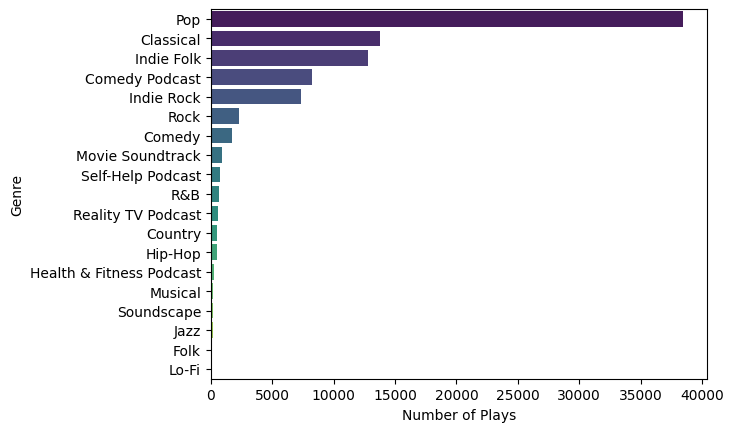

Text(0.5, 1.0, 'Total Genre Counts')

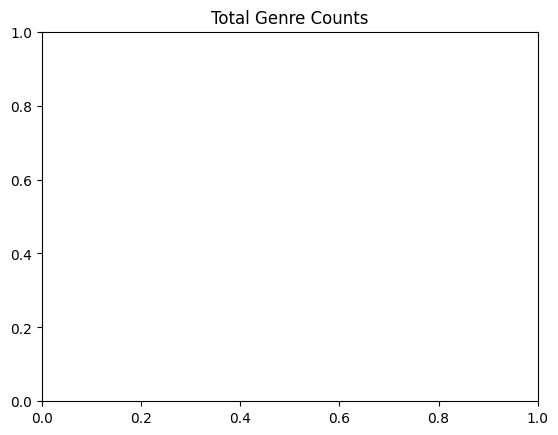

In [532]:
total_genre_counts_df = total_genre_counts.reset_index()
total_genre_counts_df.columns = ['genre', 'count']
sns.barplot(x='count', y='genre', data=total_genre_counts_df, hue='genre', palette='viridis')
plt.xlabel('Number of Plays')
plt.ylabel('Genre')
plt.show()
plt.title('Total Genre Counts')

C:\Users\14014\AppData\Local\Temp\ipykernel_14000\2649594374.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\14014\AppData\Local\Temp\ipykernel_14000\2649594374.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



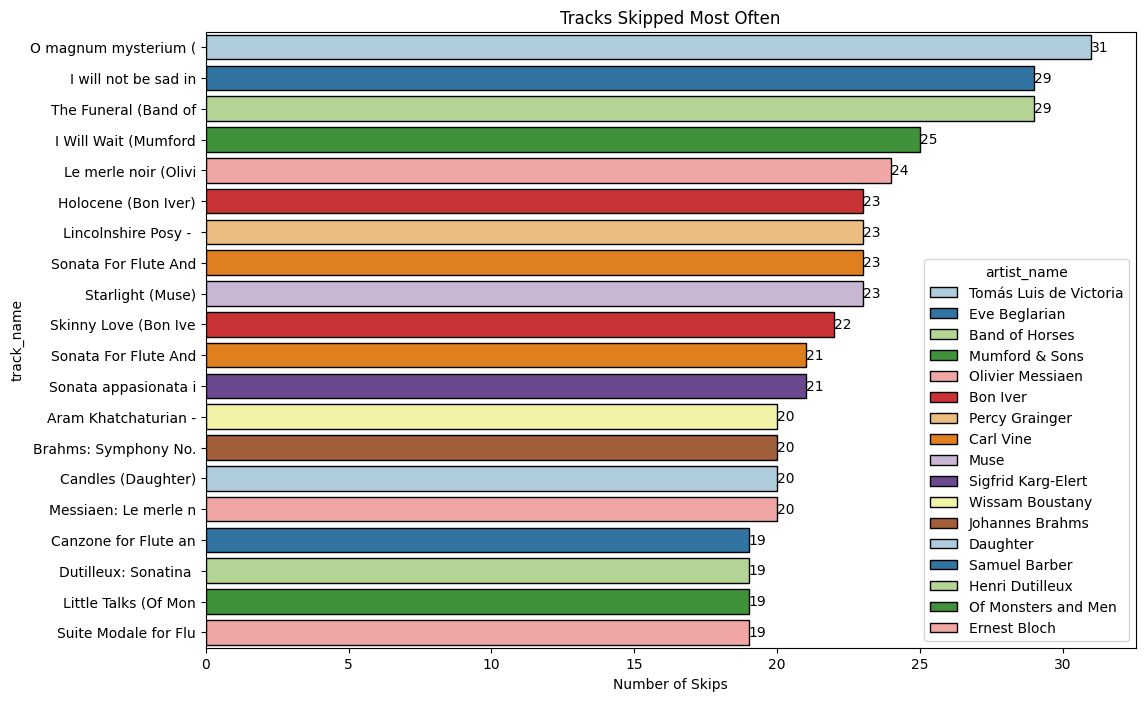

In [533]:
filtered_skipped_tracks = df[(df['skipped'] == True) & (df['track_name'] != '')]
skipped_track_counts = filtered_skipped_tracks.groupby(['track_name', 'artist_name']).size().reset_index(name='counts')
top_20_skipped_tracks = skipped_track_counts.nlargest(20, 'counts')
plt.figure(figsize=(12,8))
ax = sns.barplot(x='counts', y='track_name', hue='artist_name', data=top_20_skipped_tracks, palette='Paired', edgecolor='black')
plt.title('Tracks Skipped Most Often')
plt.xlabel('Number of Skips')
for index, value in enumerate(top_20_skipped_tracks['counts']):
    plt.text(value, index, str(value), va='center')
new_labels = [f"{track} ({artist})" for track, artist in zip(top_20_skipped_tracks['track_name'], top_20_skipped_tracks['artist_name'])]
ax.set_yticklabels(new_labels)
ax.set_yticklabels([label[:20] for label in new_labels])
plt.show()

In [534]:
unskipped_tracks = df[(df['skipped'] == False) & (df['track_name'] != '')]
num_unskipped_tracks = unskipped_tracks['track_name'].nunique()
print(f"Number of tracks that have never been skipped: {num_unskipped_tracks}")

Number of tracks that have never been skipped: 3479


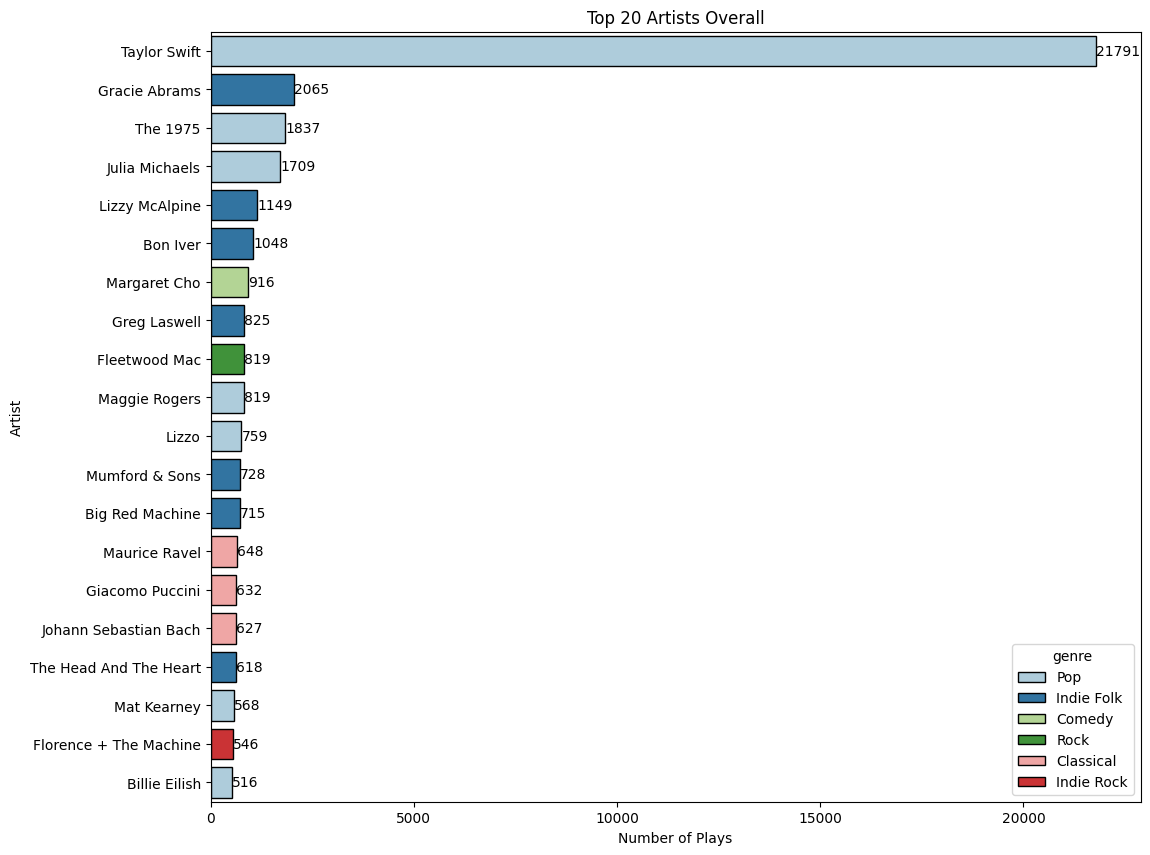

In [535]:
filtered_artists = df[df['artist_name'].str.strip() != '']
artist_counts = filtered_artists.groupby(['artist_name', 'genre']).size().reset_index(name='counts')
top_20_artists = artist_counts.nlargest(20, 'counts')

plt.figure(figsize=(12,10))
sns.barplot(x='counts', y='artist_name', hue='genre', data=top_20_artists, palette='Paired', edgecolor='black')
plt.xlabel('Number of Plays')
for index, value in enumerate(top_20_artists['counts']):
    plt.text(value, index, str(value), va='center')
plt.ylabel('Artist')
plt.title('Top 20 Artists Overall')
plt.show()

In [ ]:
yearly_counts = df.groupby(['year', 'artist_name']).size().reset_index(name='counts')
yearly_pivot = yearly_counts.pivot(index='year', columns='artist_name', values='counts').fillna(0)

X = yearly_pivot.index.values.reshape(-1, 1)
trends = {}
for artist in yearly_pivot.columns:
    y = yearly_pivot[artist]
    model = sm.OLS(y, sm.add_constant(X)).fit()
    trends[artist] = model.params[1]
sorted_trends = sorted(trends.items(), key=lambda x: x[1], reverse=True)
filtered_trends = [item for item in sorted_trends if item[0] != '']
artists = [item[0] for item in filtered_trends]
trend_values = [item[1] for item in filtered_trends]

yearly_counts = df.groupby(['year', 'artist_name']).size().reset_index(name='counts')
filtered_yearly_counts = yearly_counts[yearly_counts['artist_name'].isin(artists[:10])] 
pivot = filtered_yearly_counts.pivot(index='year', columns='artist_name', values='counts').fillna(0)


C:\Users\14014\AppData\Local\Temp\ipykernel_14000\2196382653.py:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\14014\AppData\Local\Temp\ipykernel_14000\2196382653.py:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\14014\AppData\Local\Temp\ipykernel_14000\2196382653.py:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\14014\AppData\Local\Temp\ipykernel_14000\2196382653.py:9: FutureWarning:

Series.__getit

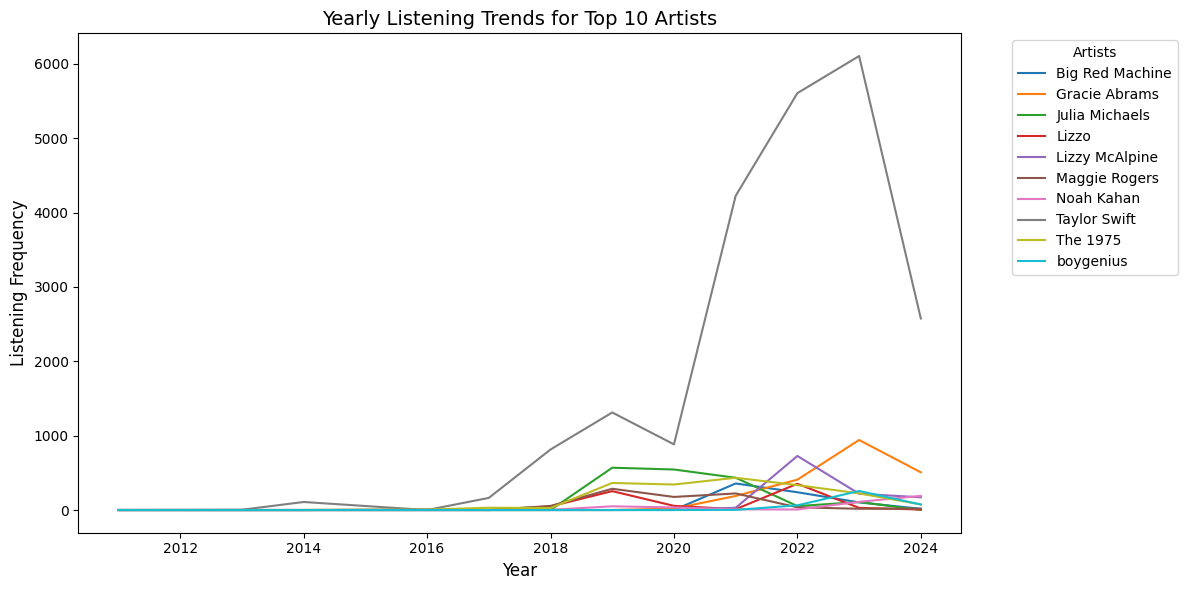

In [537]:
pivot.plot(kind='line', figsize=(12, 6))
plt.title('Yearly Listening Trends for Top 10 Artists', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Listening Frequency', fontsize=12)
plt.legend(title='Artists', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

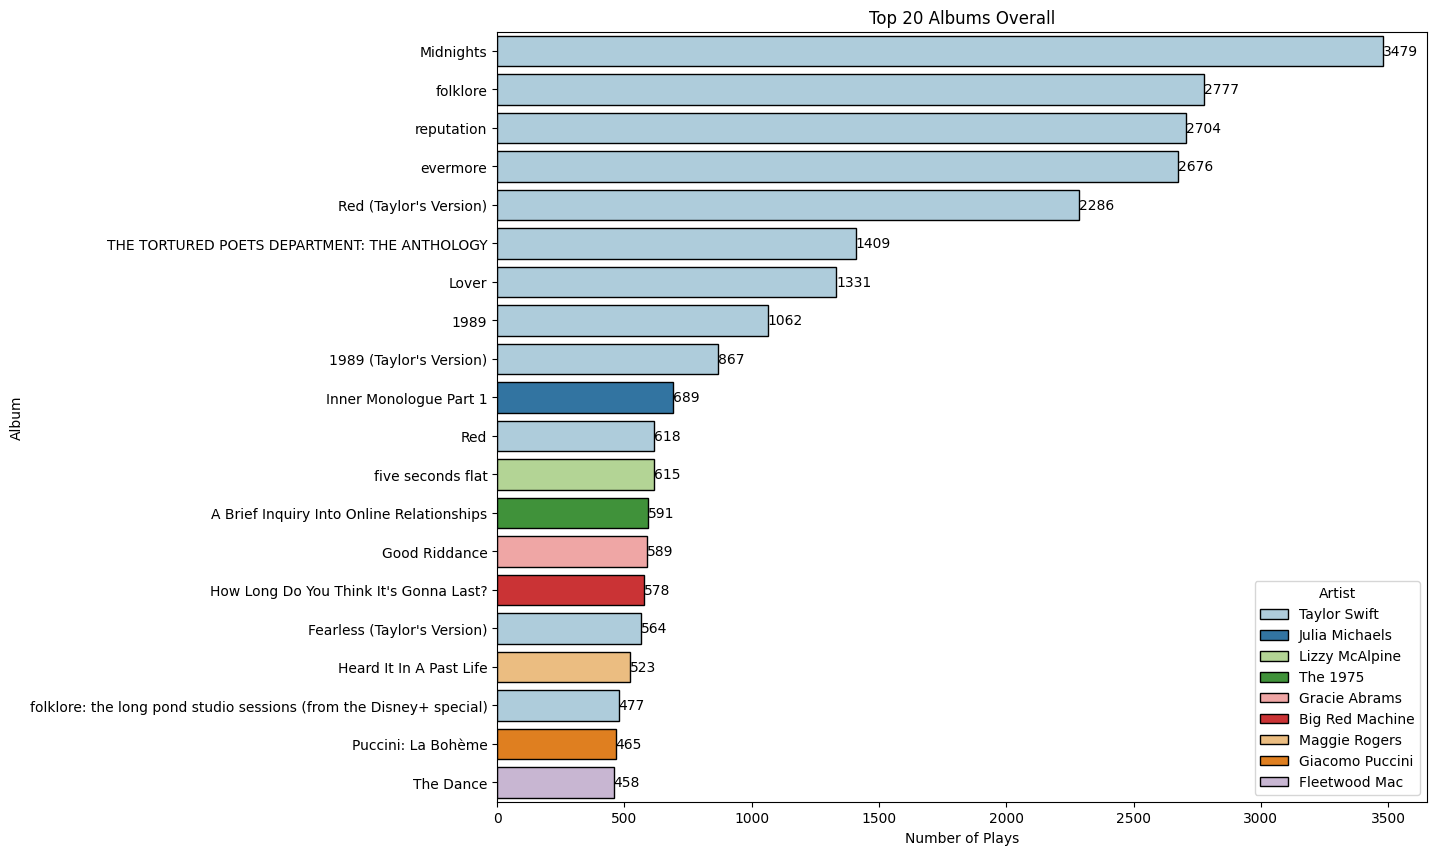

In [538]:
filtered_albums = df[df['album_name'].str.strip() != '']
album_artist_counts = filtered_albums.groupby(['album_name', 'artist_name']).size().reset_index(name='counts')
top_20_albums = album_artist_counts.nlargest(20, 'counts')

plt.figure(figsize=(12,10))
sns.barplot(x='counts', y='album_name', hue='artist_name', data=top_20_albums, palette='Paired', edgecolor='black')
plt.xlabel('Number of Plays')
for index, value in enumerate(top_20_albums['counts']):
    plt.text(value, index, str(value), va='center')
plt.ylabel('Album')
plt.title('Top 20 Albums Overall')
plt.legend(title='Artist')
plt.show()

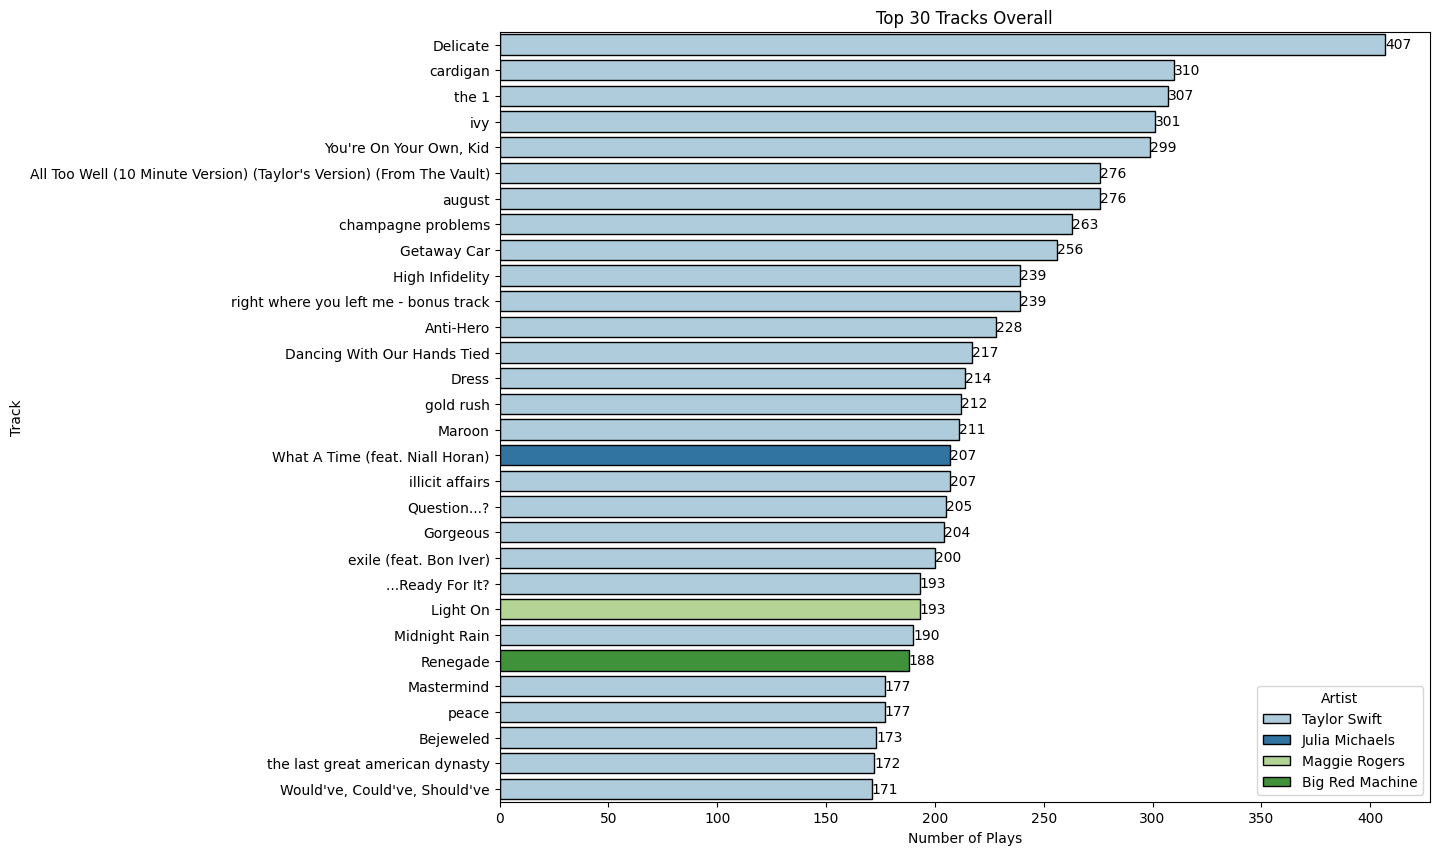

In [539]:
filtered_tracks = df[df['track_name'].str.strip() != '']
track_counts = filtered_tracks.groupby(['track_name', 'artist_name']).size().reset_index(name='counts')
top_30_tracks = track_counts.nlargest(30, 'counts')

plt.figure(figsize=(12,10))
sns.barplot(x='counts', y='track_name', hue='artist_name', data=top_30_tracks, palette='Paired', edgecolor='black')
plt.xlabel('Number of Plays')
for index, value in enumerate(top_30_tracks['counts']):
    plt.text(value, index, str(value), va='center')
plt.ylabel('Track')
plt.title('Top 30 Tracks Overall')
plt.legend(title='Artist')
plt.show()

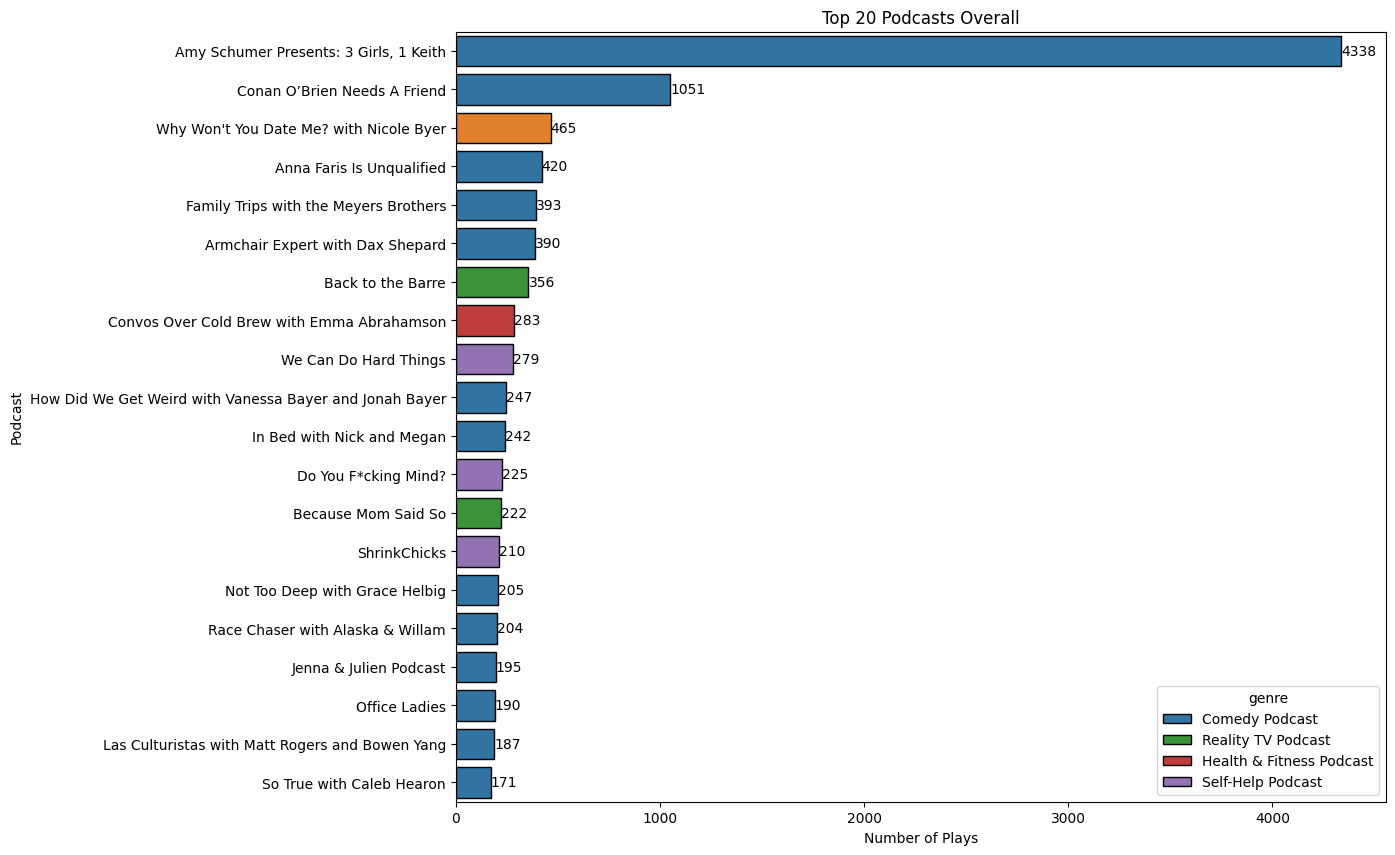

In [540]:
pod_no_music = df[df['podcast_name'] != '']
top_20_pods = pod_no_music.groupby(['podcast_name', 'genre']).size().nlargest(20).reset_index(name='counts')
plt.figure(figsize=(12, 10))
sns.barplot(x='counts', y='podcast_name', data=top_20_pods, hue='genre', edgecolor='black')
plt.xlabel('Number of Plays')
for index, value in enumerate(top_20_pods['counts']):
    plt.text(value, index, str(value), va='center')
plt.ylabel('Podcast')
plt.title('Top 20 Podcasts Overall')
plt.show()

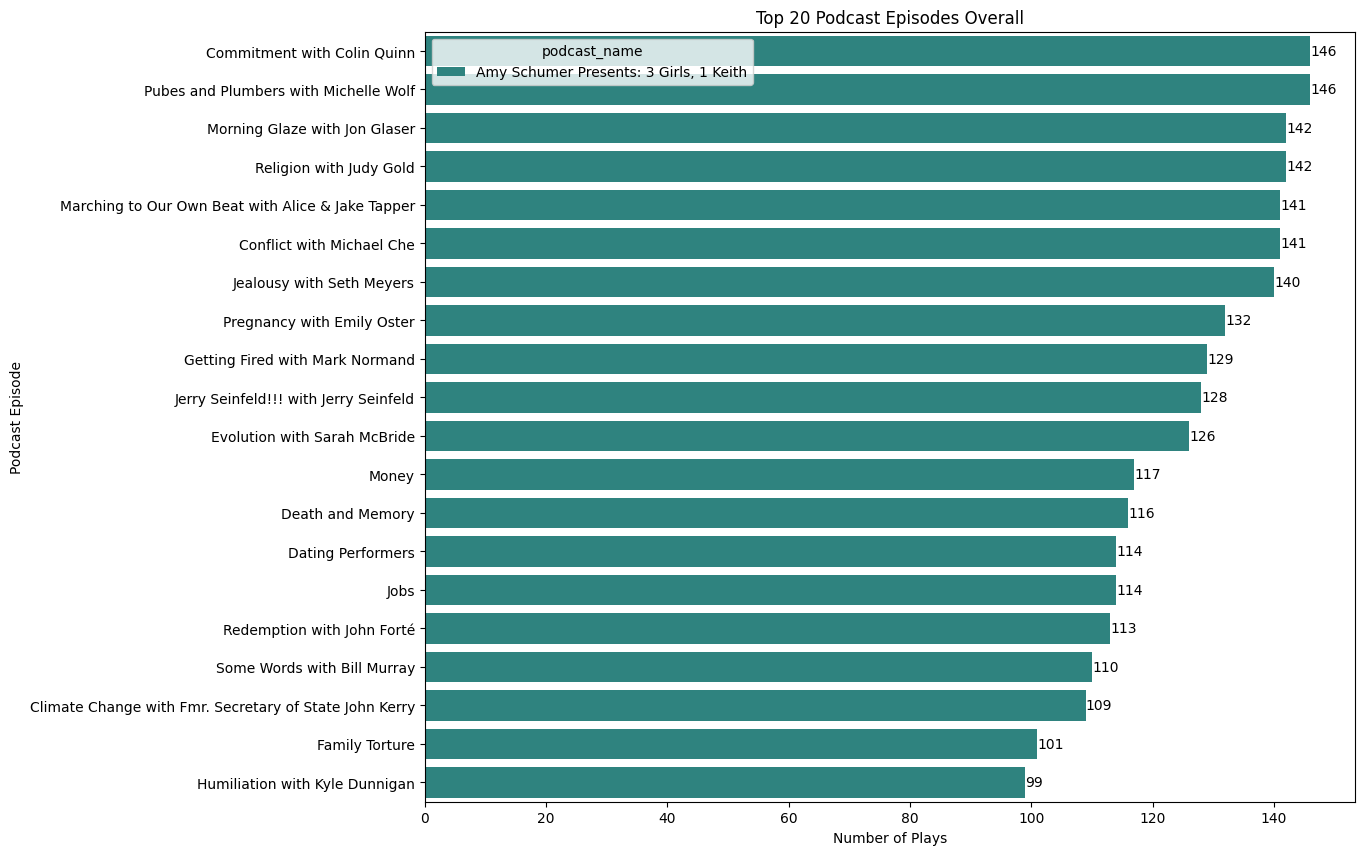

In [541]:
filtered_eps = df[df['episode_title'] != '']
top_20_pod_eps = filtered_eps['episode_title'].value_counts().head(20).reset_index()
top_20_pod_eps.columns = ['episode_title', 'count']
top_20_pod_eps = top_20_pod_eps.merge(filtered_eps[['episode_title', 'podcast_name']].drop_duplicates(), on='episode_title', how='left')
plt.figure(figsize=(12, 10))
sns.barplot(x='count', y='episode_title', hue='podcast_name', data=top_20_pod_eps, palette='viridis')
plt.xlabel('Number of Plays')
for index, value in enumerate(top_20_pod_eps['count']):
    plt.text(value, index, str(value), va='center')
plt.ylabel('Podcast Episode')
plt.title('Top 20 Podcast Episodes Overall')
plt.show()

In [542]:
from sklearn.linear_model import LinearRegression

artist_trend = artist_trend[artist_trend['artist_name'].notnull() & (artist_trend['artist_name'] != '')]

artist_trends = []

for artist in artist_trend['artist_name'].unique():
    sub_data = artist_trend[artist_trend['artist_name'] == artist]
    if len(sub_data) > 1:
        model = LinearRegression()
        model.fit(sub_data[['year']], sub_data['ms_played'])
        trend = model.coef_[0]
        artist_trends.append({'artist_name': artist, 'trend': trend})

artist_trend_df = pd.DataFrame(artist_trends)

top_positive_artists = artist_trend_df.nlargest(10, 'trend')  
top_negative_artists = artist_trend_df.nsmallest(10, 'trend') 

print(f"Top Positive Trending Artists Over Time:")
pprint(top_positive_artists)
print(f"Top Negative Trending Artists Over Time:")
pprint(top_negative_artists)

Top Positive Trending Artists Over Time:
         artist_name         trend
155     Taylor Swift  5.756806e+07
1852   Gracie Abrams  3.050432e+07
2055   Chappell Roan  2.463151e+07
2067     Olivia Dean  1.181792e+07
1872  Lizzy McAlpine  7.221867e+06
1975       boygenius  6.839908e+06
478        Carl Vine  6.809647e+06
1932  Eli Young Band  6.693257e+06
1705   György Ligeti  4.782569e+06
1278        The 1975  3.796259e+06
Top Negative Trending Artists Over Time:
          artist_name         trend
1918  Big Red Machine -2.138199e+07
712      Margaret Cho -1.563888e+07
1729   Julia Michaels -1.433267e+07
2027             Rynn -8.197888e+06
831   Ellen DeGeneres -6.163168e+06
2046       niceboy ed -4.865514e+06
650     Eve Beglarian -4.302363e+06
702        Louis C.K. -4.175711e+06
1223    Patty Griffin -4.145190e+06
1993       Emmit Fenn -3.780500e+06


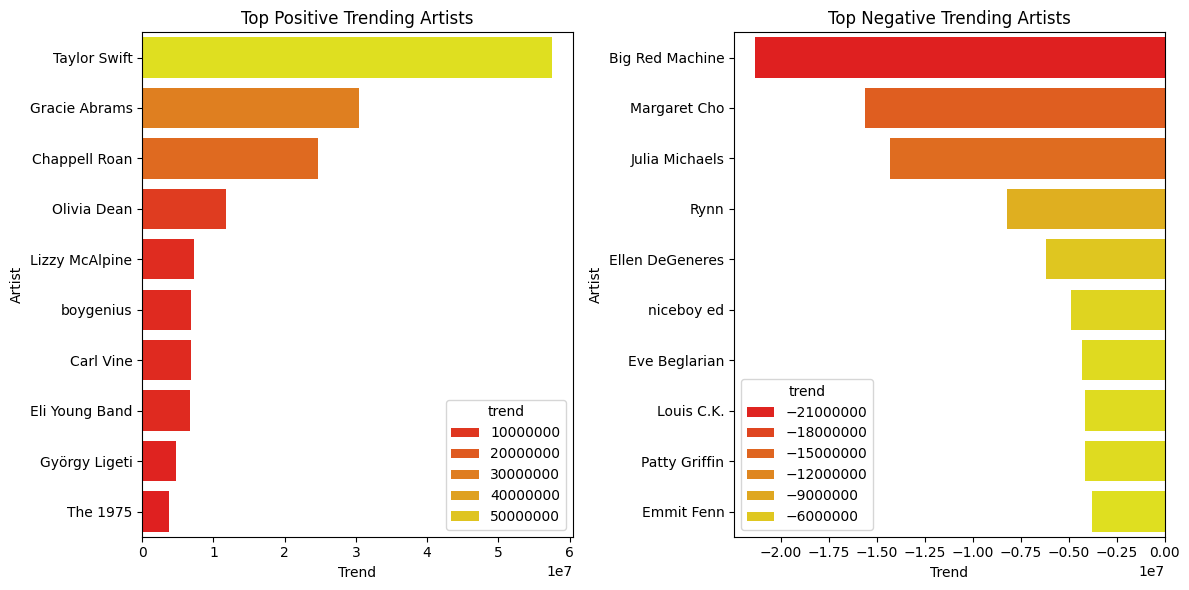

In [543]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x='trend', y='artist_name', data=top_positive_artists, hue='trend', palette='autumn', ax=ax[0])
ax[0].set_title('Top Positive Trending Artists')
ax[0].set_xlabel('Trend')
ax[0].set_ylabel('Artist')
sns.barplot(x='trend', y='artist_name', data=top_negative_artists, hue='trend', palette='autumn', ax=ax[1])
ax[1].set_title('Top Negative Trending Artists')
ax[1].set_xlabel('Trend')
ax[1].set_ylabel('Artist')
plt.tight_layout()
plt.show()

In [544]:
trend_df_album_cols = df[['album_name', 'year', 'ms_played']].dropna()

album_trend = trend_df_album_cols[trend_df_album_cols['album_name'].notnull() & (trend_df_album_cols['album_name'] != '')]

album_trends = []

for album in album_trend['album_name'].unique():
    sub_data = album_trend[album_trend['album_name'] == album]
    if len(sub_data) > 1:  
        model = LinearRegression()
        model.fit(sub_data[['year']], sub_data['ms_played'])
        trend = model.coef_[0]
        album_trends.append({'album_name': album, 'trend': trend})

album_trend_df = pd.DataFrame(album_trends)

top_positive_albums = album_trend_df.nlargest(10, 'trend')
top_negative_albums = album_trend_df.nsmallest(10, 'trend')

print(f"Top Positive Trending Albums Over Time:")
pprint(top_positive_albums)
print(f"Top Negative Trending Albums Over Time:")
pprint(top_negative_albums)


Top Positive Trending Albums Over Time:
                                             album_name         trend
1102  Richard Strauss: Der Rosenkavalier Suite, Le b...  1.020575e+06
794   Reinecke, C.: Flute Sonata, "Undine" / Von Der...  7.029560e+05
1621                              Brahms Symphony No. 1  4.030836e+05
1151                     I Want to See Pulaski at Night  3.992690e+05
3626                           La symphonie des oiseaux  3.953430e+05
1515  Schumann: Piano Concerto in A Minor, Symphony ...  3.563330e+05
3123             Beethoven: Symphony No.7 / 3 Overtures  3.225907e+05
4992     Schoepper, Vol. 1 of The Robert Hoe Collection  3.223400e+05
4584                   Walk The Moon (Expanded Edition)  3.202900e+05
4479                                    Around the Well  3.198000e+05
Top Negative Trending Albums Over Time:
                                             album_name          trend
194                        Rossini: The Great Overtures -725331.000000
3900  Kh

C:\Users\14014\AppData\Local\Temp\ipykernel_14000\121091331.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\14014\AppData\Local\Temp\ipykernel_14000\121091331.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



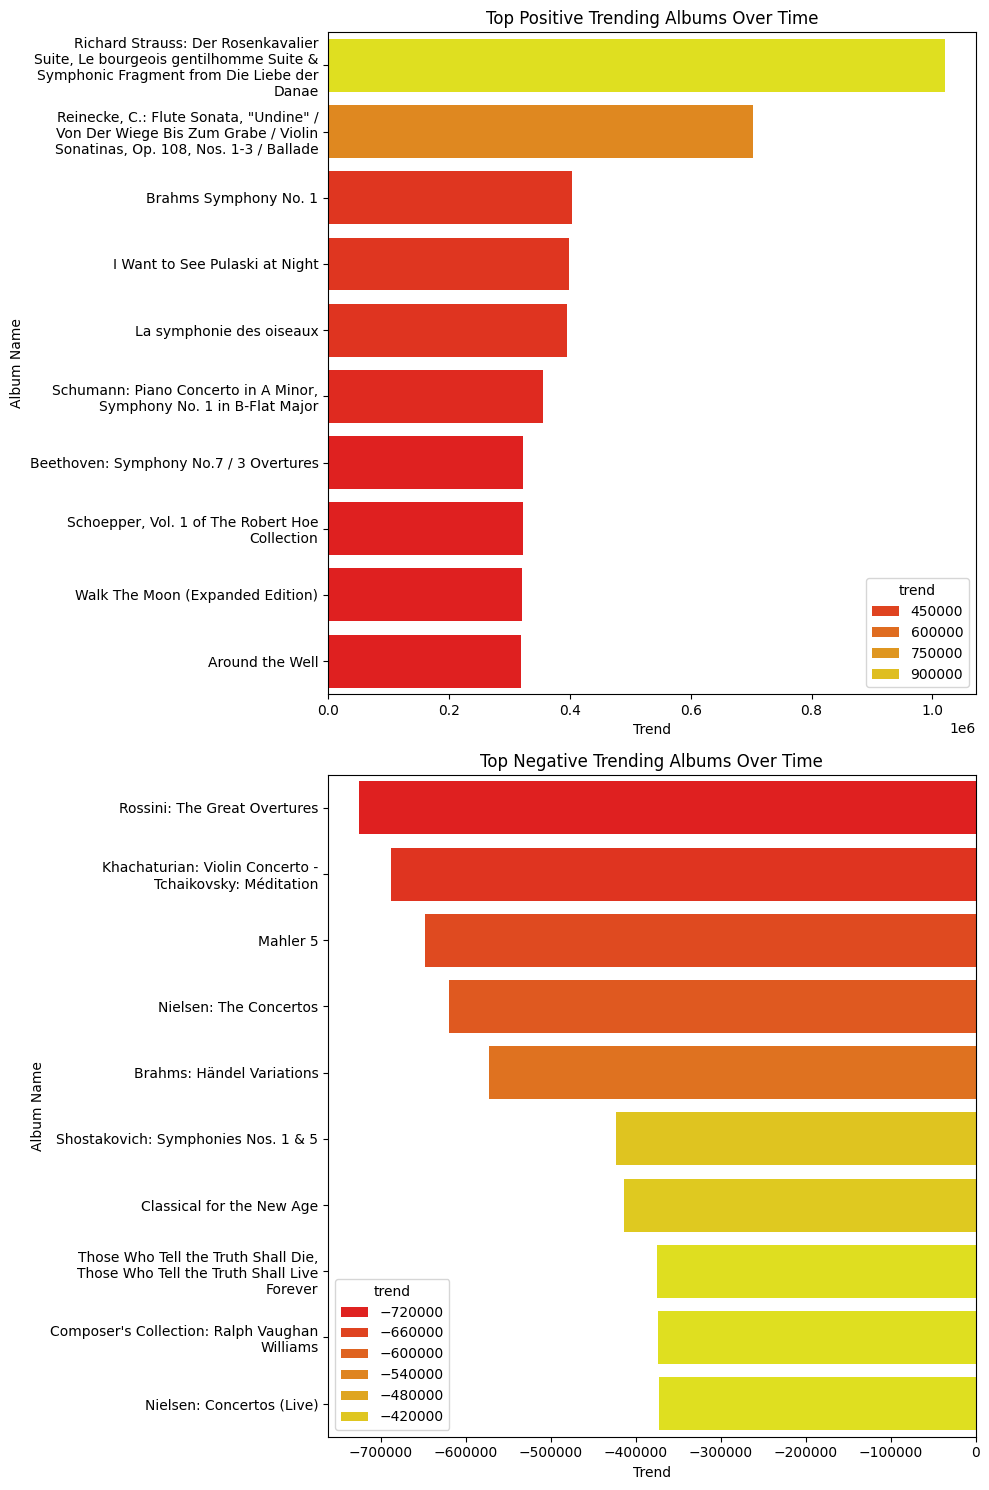

In [545]:
import textwrap
fig, ax = plt.subplots(2, 1, figsize=(10,15))

sns.barplot(x='trend', y='album_name', data=top_positive_albums, hue='trend', palette='autumn', ax=ax[0])
ax[0].set_title('Top Positive Trending Albums Over Time')
ax[0].set_xlabel('Trend')
ax[0].set_ylabel('Album Name')

def wrap_labels(ax, width):
    labels = [label.get_text() for label in ax.get_yticklabels()]
    wrapped_labels = ['\n'.join(textwrap.wrap(label, width)) for label in labels]
    ax.set_yticklabels(wrapped_labels)

wrap_labels(ax[0], 40)

sns.barplot(x='trend', y='album_name', data=top_negative_albums, hue='trend', palette='autumn', ax=ax[1])
ax[1].set_title('Top Negative Trending Albums Over Time')
ax[1].set_xlabel('Trend')
ax[1].set_ylabel('Album Name')
wrap_labels(ax[1], 40)


plt.tight_layout()
plt.show()

In [546]:

trend_df_track_cols = df[['track_name', 'year', 'ms_played']].dropna()
track_trend = trend_df_track_cols[trend_df_track_cols['track_name'].notnull() & (trend_df_track_cols['track_name'] != '')]

track_trends = []

for track in track_trend['track_name'].unique():
    sub_data = track_trend[track_trend['track_name'] == track]
    if len(sub_data) > 1:  
        model = LinearRegression()
        model.fit(sub_data[['year']], sub_data['ms_played'])
        trend = model.coef_[0]
        track_trends.append({'track_name': track, 'trend': trend})

track_trend_df = pd.DataFrame(track_trends)

top_positive_tracks = track_trend_df.nlargest(10, 'trend')
top_negative_tracks = track_trend_df.nsmallest(10, 'trend')

print(f"Top Positive Trending Tracks Over Time:")
pprint(top_positive_tracks)
print(f"Top Negative Trending Tracks Over Time:")
pprint(top_negative_tracks)


Top Positive Trending Tracks Over Time:
                                             track_name         trend
1802                  Der Rosenkavalier Suite, TrV 227d  1.020575e+06
131   Tchaikovsky: Symphony No. 5 in E Minor, Op. 64...  9.134070e+05
2837  Brahms: Symphony No. 1 in C minor Op. 68: Un p...  8.353798e+05
2866  Brahms: Symphony No. 3 in F Major, Op. 90: I. ...  7.868667e+05
3630                   Symphony No. 6, Op. 54: I. Largo  6.984831e+05
2865  Brahms: Symphony No. 3 in F Major, Op. 90: IV....  5.754770e+05
2870  Brahms: Symphony No. 3 in F Major, Op. 90: II....  5.680020e+05
3715                                       RAAAAAAAANDY  5.345320e+05
7528                                        Next To You  4.921643e+05
6318  Khachaturian: Flute Concerto: II. Andante sost...  4.231553e+05
Top Negative Trending Tracks Over Time:
                                             track_name         trend
134   Tchaikovsky: Symphony No. 5 in E Minor, Op. 64... -1.088107e+06
6363  Khac

C:\Users\14014\AppData\Local\Temp\ipykernel_14000\374764441.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\14014\AppData\Local\Temp\ipykernel_14000\374764441.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



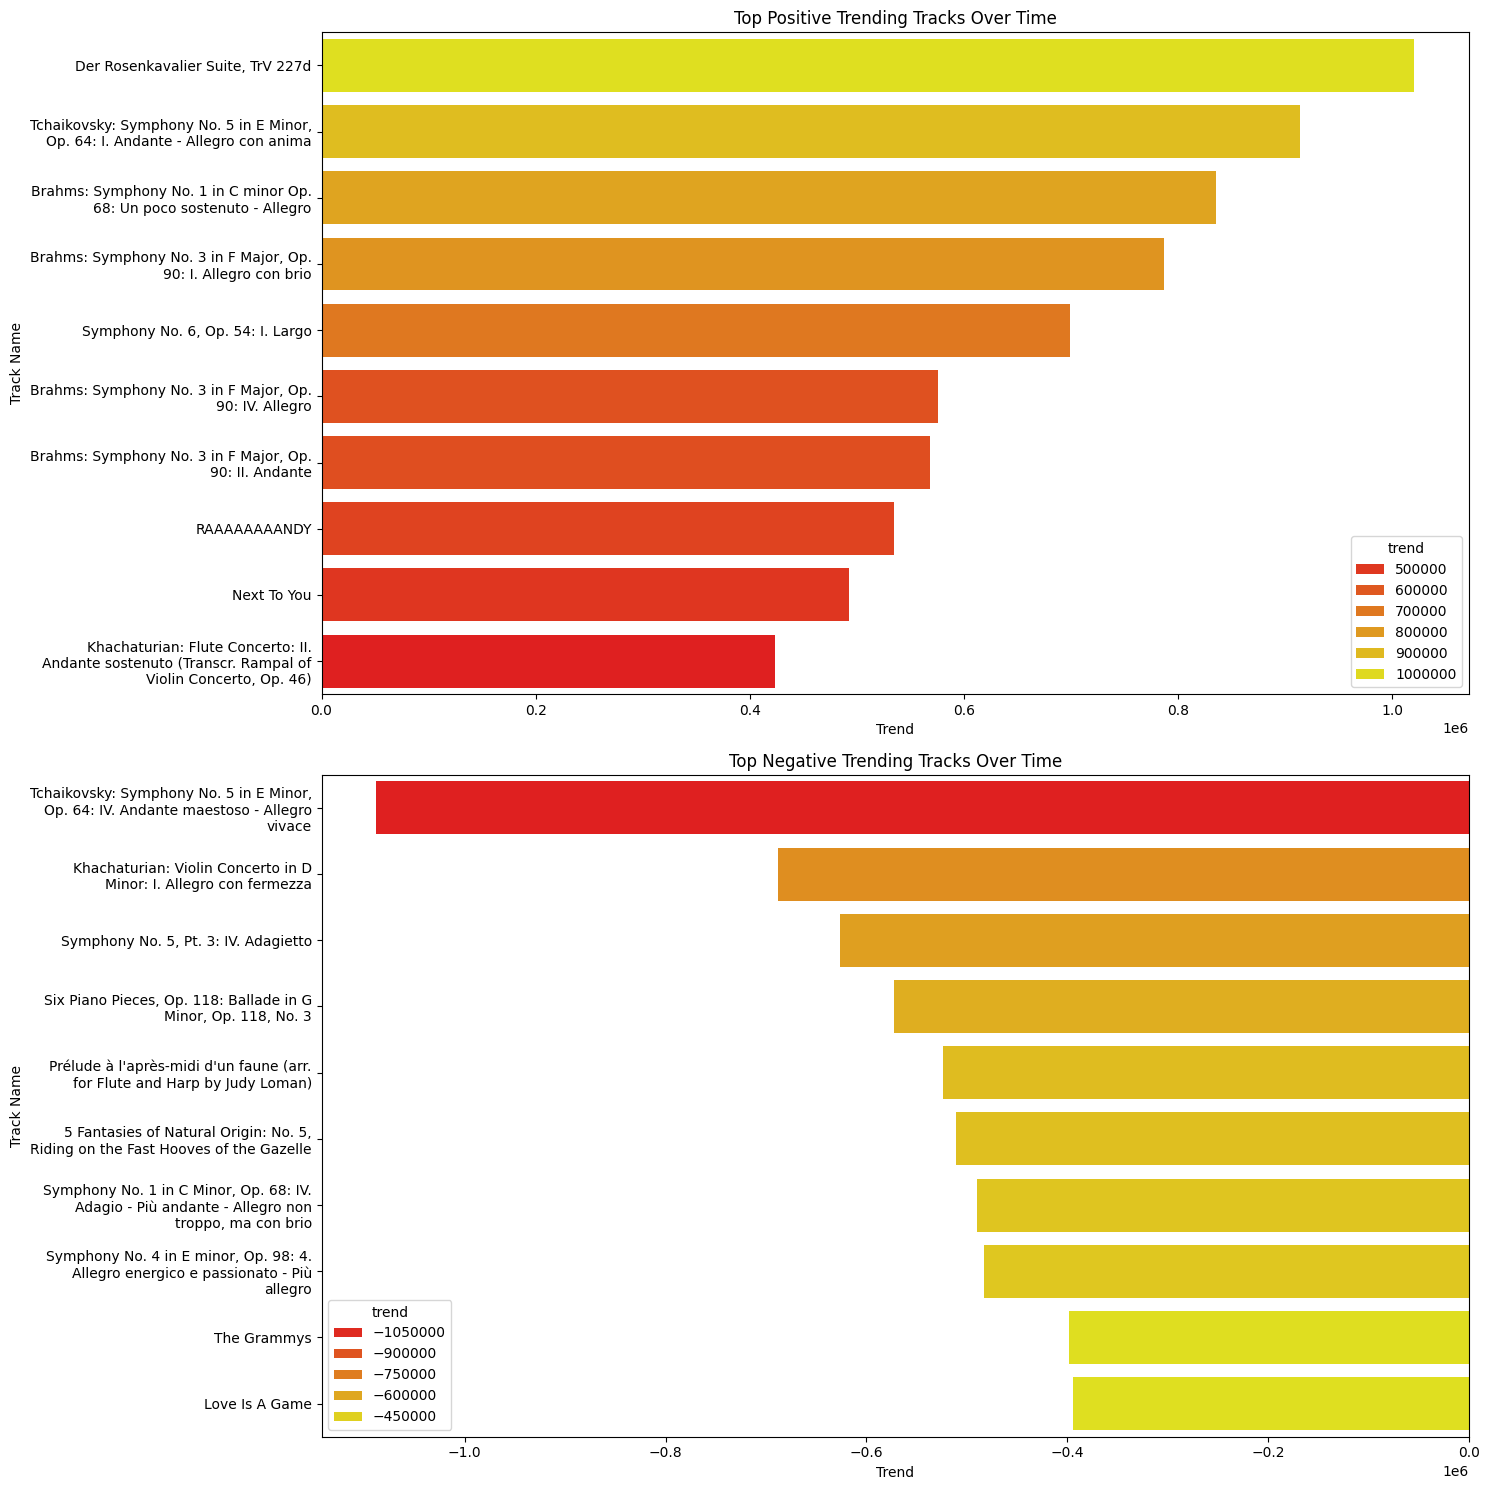

In [547]:
fig, ax = plt.subplots(2,1, figsize=(15,15))

sns.barplot(x='trend', y='track_name', data=top_positive_tracks, hue='trend', palette='autumn', ax=ax[0])
ax[0].set_title('Top Positive Trending Tracks Over Time')
ax[0].set_xlabel('Trend')
ax[0].set_ylabel('Track Name')

def wrap_labels(ax, width):
    labels = [label.get_text() for label in ax.get_yticklabels()]
    wrapped_labels = ['\n'.join(textwrap.wrap(label, width)) for label in labels]
    ax.set_yticklabels(wrapped_labels)

wrap_labels(ax[0], 40)

sns.barplot(x='trend', y='track_name', data=top_negative_tracks, hue='trend', palette='autumn', ax=ax[1])
ax[1].set_title('Top Negative Trending Tracks Over Time')
ax[1].set_xlabel('Trend')
ax[1].set_ylabel('Track Name')
wrap_labels(ax[1], 40)

plt.tight_layout()
plt.show()

In [548]:
trend_df_genre_cols = df[['genre', 'year', 'ms_played']].dropna()
genre_trend = trend_df_genre_cols[trend_df_genre_cols['genre'].notnull() & (trend_df_genre_cols['genre'] != '')]

genre_trends = []

for genre in genre_trend['genre'].unique():
    sub_data = genre_trend[genre_trend['genre'] == genre]
    if len(sub_data) > 1:  
        model = LinearRegression()
        model.fit(sub_data[['year']], sub_data['ms_played'])
        trend = model.coef_[0]
        genre_trends.append({'genre': genre, 'trend': trend})

genre_trend_df = pd.DataFrame(genre_trends)

top_positive_genres = genre_trend_df.nlargest(5, 'trend')
top_negative_genres = genre_trend_df.nsmallest(5, 'trend')

print(f"Top Positive Trending Genres Over Time:")
pprint(top_positive_genres)

print(f"Top Negative Trending Genres Over Time:")
pprint(top_negative_genres)

Top Positive Trending Genres Over Time:
                 genre          trend
16  Reality TV Podcast  601440.403224
13      Comedy Podcast   79591.476837
14          Soundscape    8188.908600
4                  R&B    6733.613251
0                  Pop    1463.315171
Top Negative Trending Genres Over Time:
                       genre          trend
17         Self-Help Podcast -138615.727985
18                     Lo-Fi  -61431.916667
12                    Comedy  -25127.570054
15  Health & Fitness Podcast  -13525.032487
10                      Jazz  -11514.105205


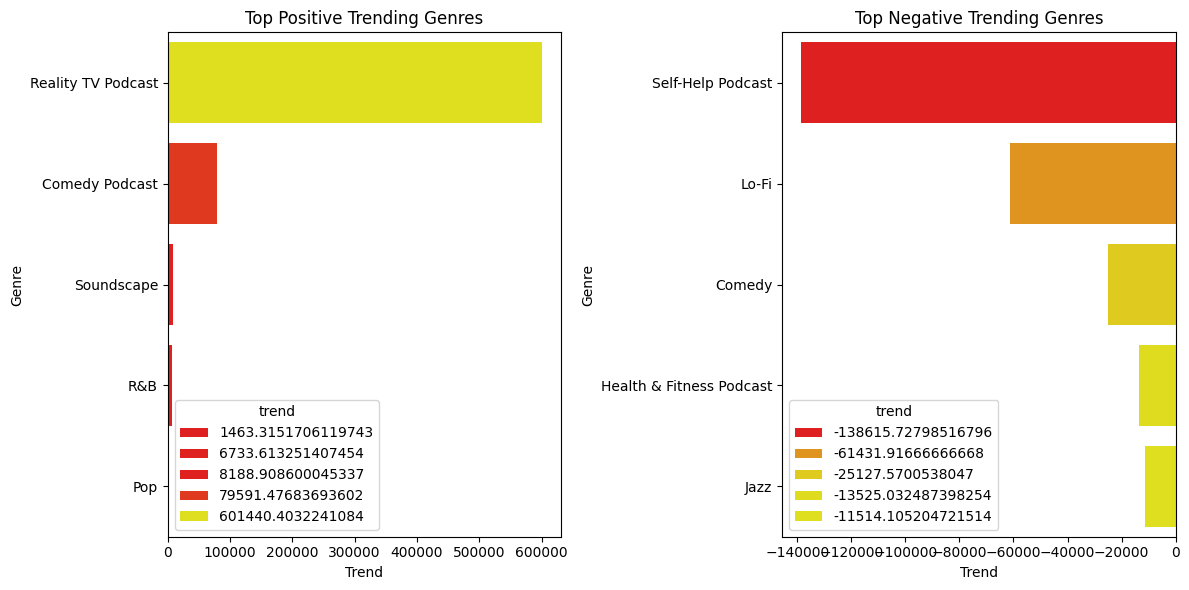

In [549]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x='trend', y='genre', data=top_positive_genres, hue='trend', palette='autumn', ax=ax[0])
ax[0].set_title('Top Positive Trending Genres')
ax[0].set_xlabel('Trend')
ax[0].set_ylabel('Genre')
sns.barplot(x='trend', y='genre', data=top_negative_genres, hue='trend', palette='autumn', ax=ax[1])
ax[1].set_title('Top Negative Trending Genres')
ax[1].set_xlabel('Trend')
ax[1].set_ylabel('Genre')
plt.tight_layout()
plt.show()

In [550]:
from sklearn.linear_model import LinearRegression

trend_df_podcast_cols = df[['podcast_name', 'year', 'ms_played']].dropna()
podcast_trend = trend_df_podcast_cols[trend_df_podcast_cols['podcast_name'].notnull() & (trend_df_podcast_cols['podcast_name'] != '')]

podcast_trends = []

for podcast in podcast_trend['podcast_name'].unique():
    sub_data = podcast_trend[podcast_trend['podcast_name'] == podcast]
    if len(sub_data) > 1:  
        model = LinearRegression()
        model.fit(sub_data[['year']], sub_data['ms_played'])
        trend = model.coef_[0]
        podcast_trends.append({'podcast_name': podcast, 'trend': trend})

podcast_trend_df = pd.DataFrame(podcast_trends)

top_positive_pods = podcast_trend_df.nlargest(10, 'trend')
top_negative_pods = podcast_trend_df.nsmallest(10, 'trend')

print(top_positive_pods)
print(top_negative_pods)

                                          podcast_name         trend
83                                   Podcast: The Ride  3.184130e+06
101                       The Mind Over Finger Podcast  2.384648e+06
72                                   The Writers Panel  2.231591e+06
28                    Off Book: The Improvised Musical  2.152539e+06
265                           The Nikki Glaser Podcast  1.855998e+06
76                     Next Question with Katie Couric  1.821083e+06
155  Nothing much happens: bedtime stories to help ...  1.754700e+06
30                Alison Rosen Is Your New Best Friend  1.738340e+06
112                                 This American Life  1.623672e+06
109                  Under The Skin with Russell Brand  1.615309e+06
                                          podcast_name         trend
21            Never Not Funny: The Jimmy Pardo Podcast -2.241214e+06
82                                       Totally Laime -1.731854e+06
307                           The 

C:\Users\14014\AppData\Local\Temp\ipykernel_14000\2413633269.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\14014\AppData\Local\Temp\ipykernel_14000\2413633269.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



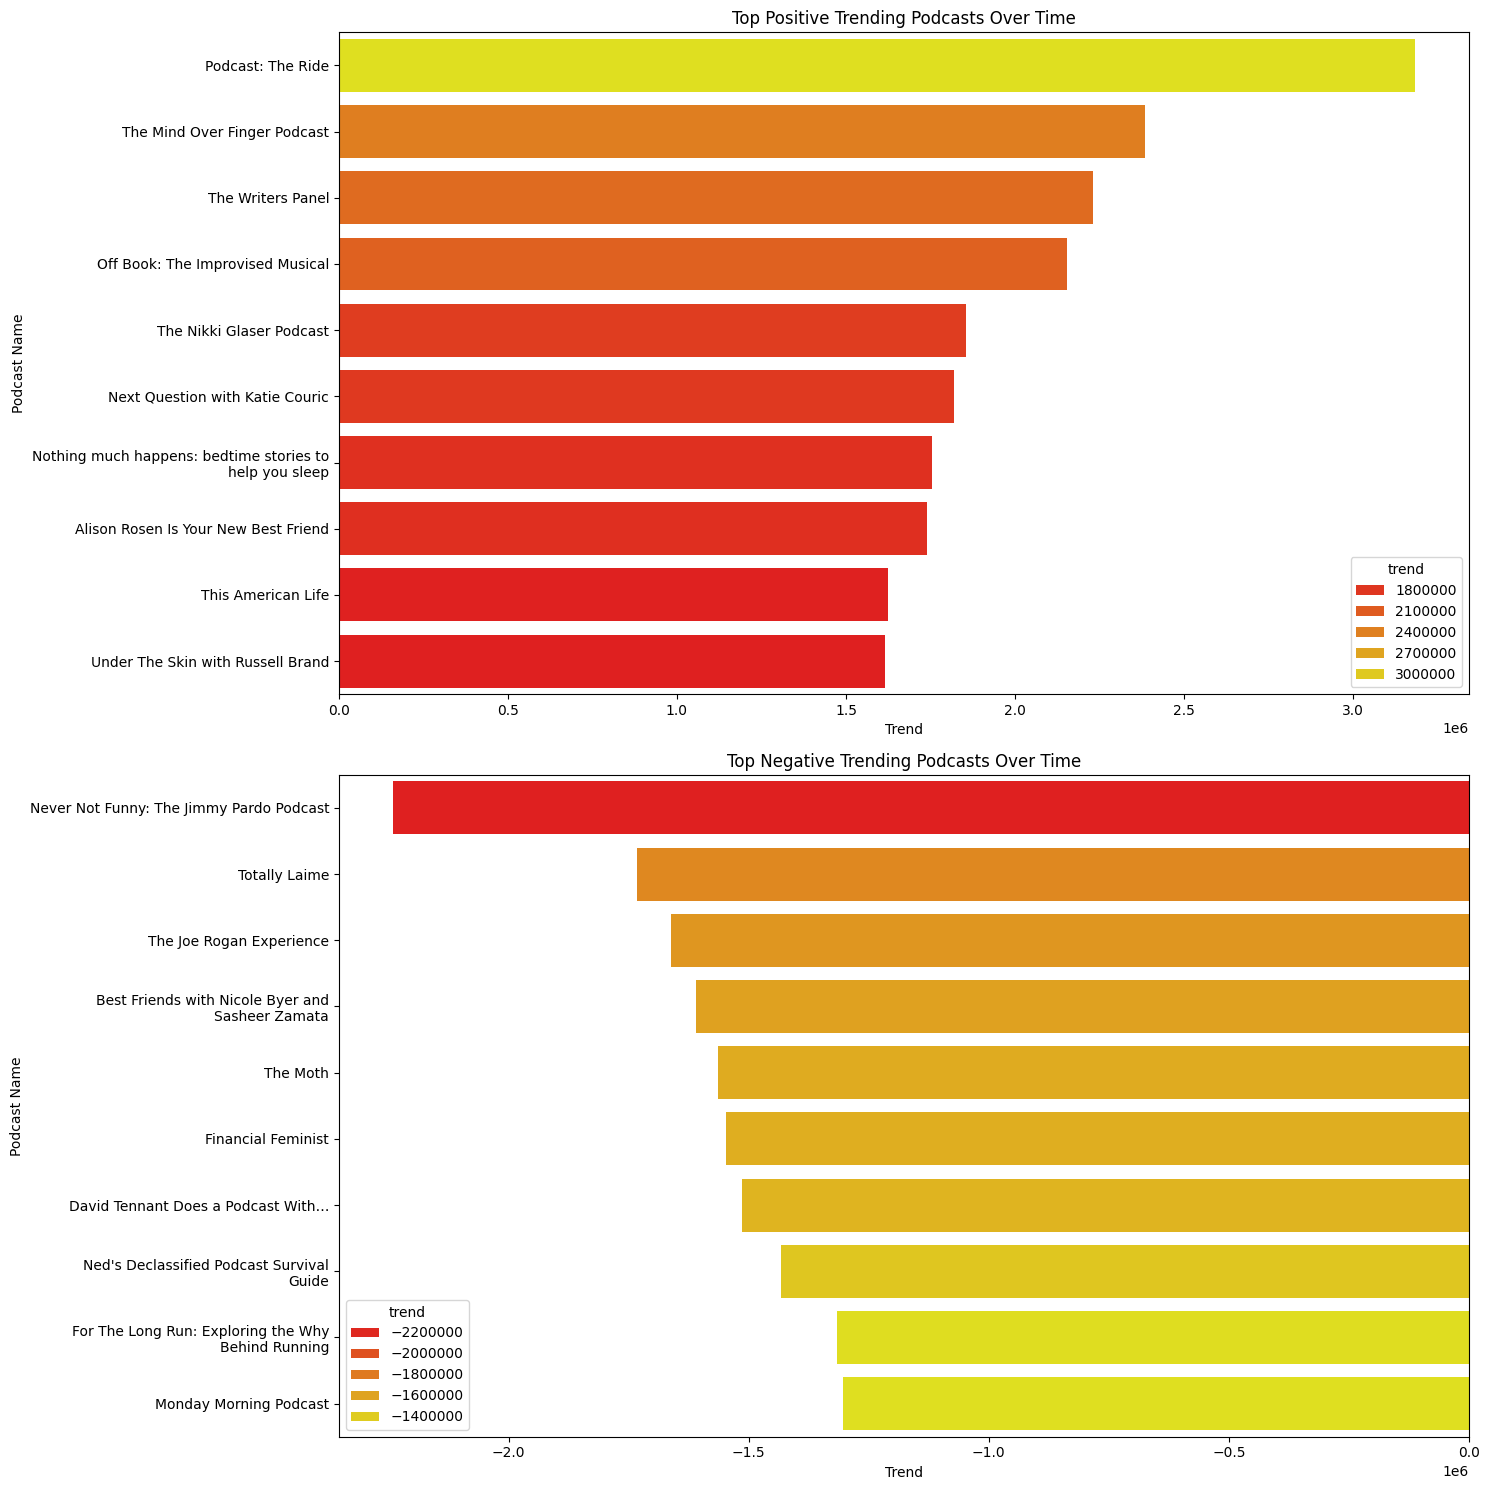

In [551]:
fig, ax = plt.subplots(2,1, figsize=(15,15))

sns.barplot(x='trend', y='podcast_name', data=top_positive_pods, hue='trend', palette='autumn', ax=ax[0])
ax[0].set_title('Top Positive Trending Podcasts Over Time')
ax[0].set_xlabel('Trend')
ax[0].set_ylabel('Podcast Name')

def wrap_labels(ax, width):
    labels = [label.get_text() for label in ax.get_yticklabels()]
    wrapped_labels = ['\n'.join(textwrap.wrap(label, width)) for label in labels]
    ax.set_yticklabels(wrapped_labels)

wrap_labels(ax[0], 40)

sns.barplot(x='trend', y='podcast_name', data=top_negative_pods, hue='trend', palette='autumn', ax=ax[1])
ax[1].set_title('Top Negative Trending Podcasts Over Time')
ax[1].set_xlabel('Trend')
ax[1].set_ylabel('Podcast Name')
wrap_labels(ax[1], 40)

plt.tight_layout()
plt.show()

C:\Users\14014\AppData\Local\Temp\ipykernel_14000\1143387568.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



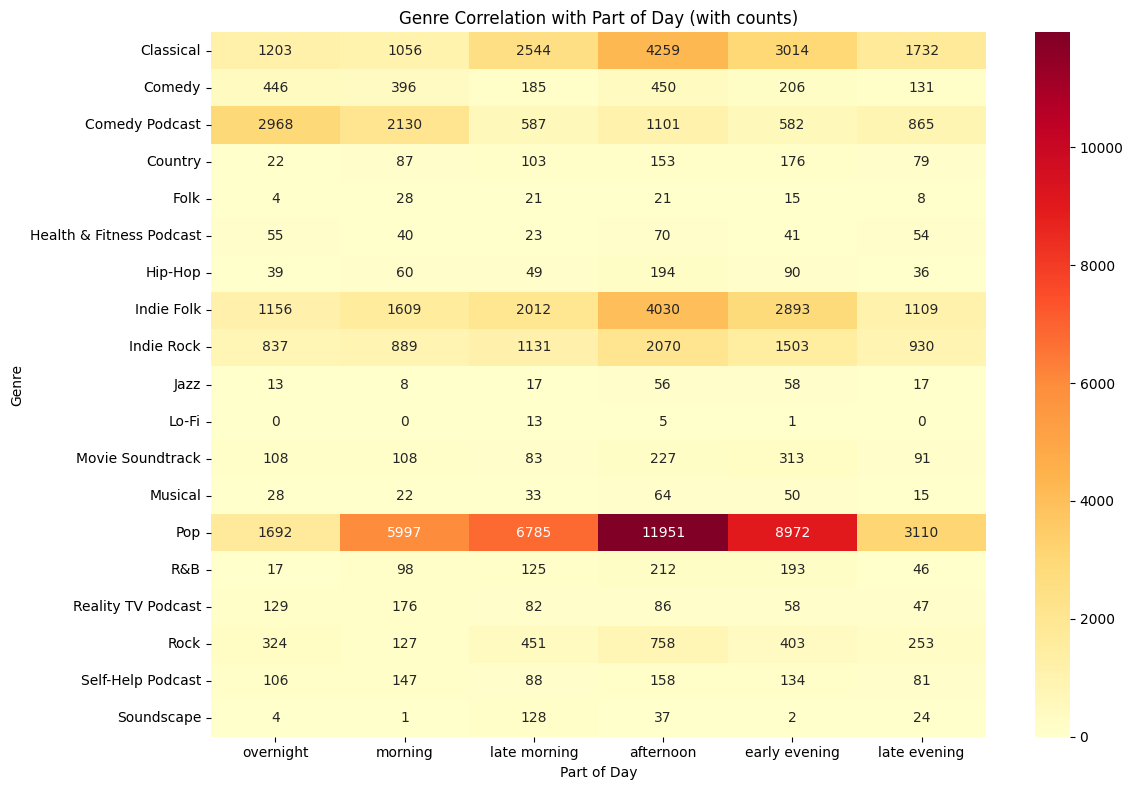

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(filtered_genre.groupby(['genre', 'part_of_day']).size().unstack(), annot=True, fmt='g', cmap='YlOrRd')
plt.xlabel('Part of Day')
plt.tight_layout()
plt.ylabel('Genre')
plt.title('Genre Correlation with Part of Day (with counts)')

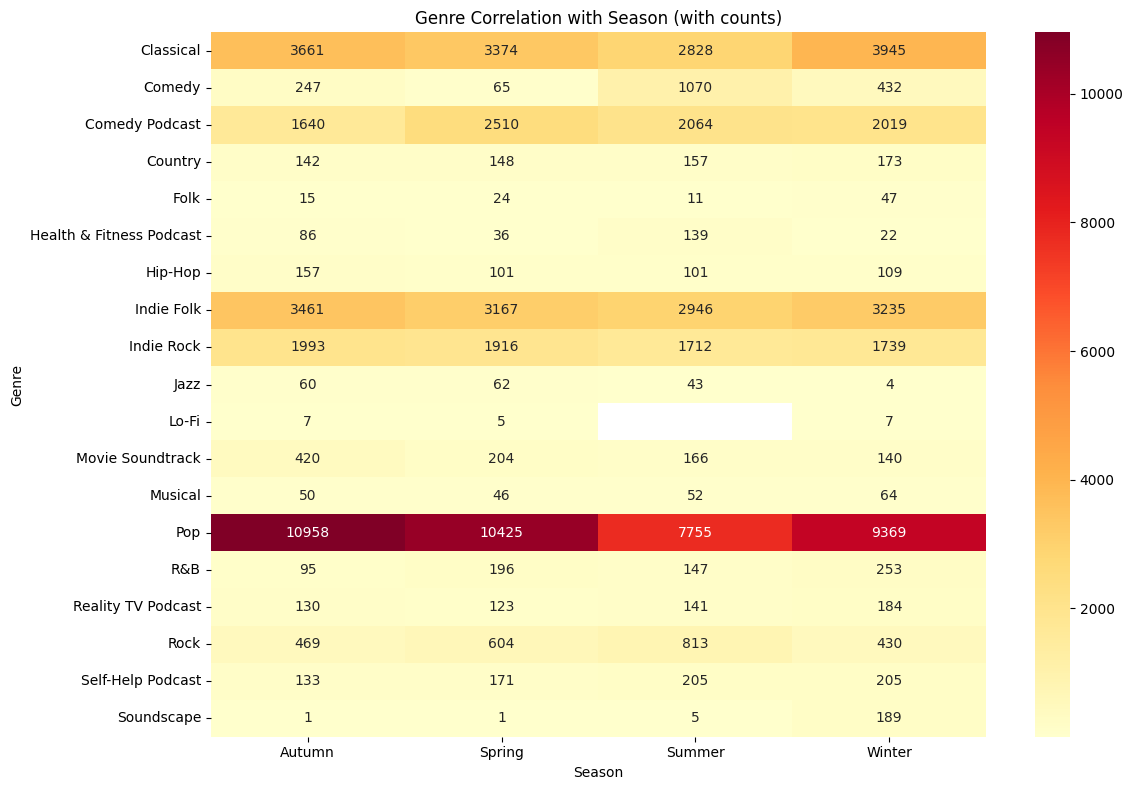

In [570]:
plt.figure(figsize=(12,8))
sns.heatmap(filtered_genre.groupby(['genre', 'season']).size().unstack(), annot=True, fmt='g', cmap='YlOrRd')
plt.xlabel('Season')
plt.ylabel('Genre')
plt.title('Genre Correlation with Season (with counts)')
plt.tight_layout()

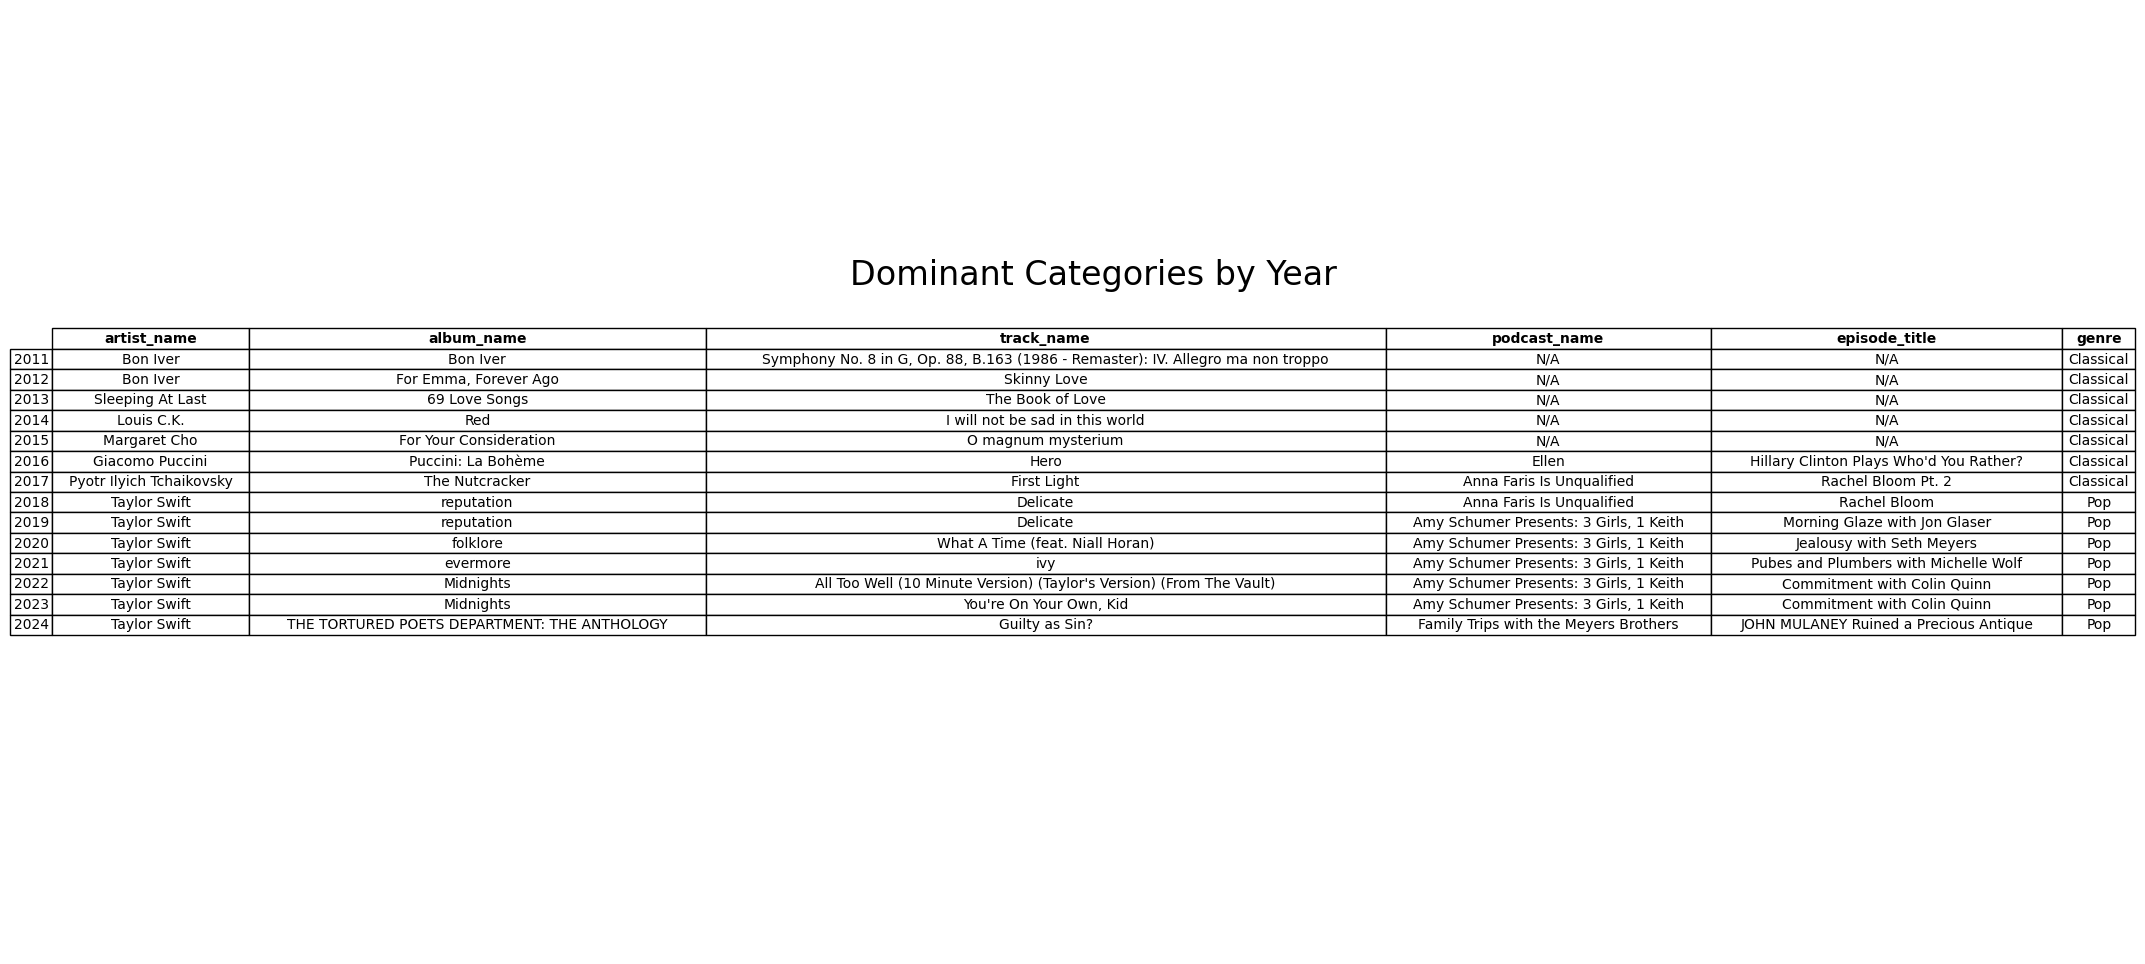

In [552]:
dominant_summary = df.groupby('year').agg({
    'artist_name': lambda x: x[x != ''].dropna().value_counts().index[0] if not x[x != ''].dropna().empty else 'N/A',
    'album_name': lambda x: x[x != ''].dropna().value_counts().index[0] if not x[x != ''].dropna().empty else 'N/A',
    'track_name': lambda x: x[x != ''].dropna().value_counts().index[0] if not x[x != ''].dropna().empty else 'N/A',
    'podcast_name': lambda x: x[x != ''].dropna().value_counts().index[0] if not x[x != ''].dropna().empty else 'N/A',
    'episode_title': lambda x: x[x != ''].dropna().value_counts().index[0] if not x[x != ''].dropna().empty else 'N/A',
    'genre': lambda x: x[x != ''].dropna().value_counts().index[0] if not x[x != ''].dropna().empty else 'N/A'
})

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('off')
table = plt.table(
    cellText=dominant_summary.values,
    colLabels=dominant_summary.columns,
    rowLabels=dominant_summary.index,
    cellLoc='center',
    loc='center',
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(dominant_summary.columns))))

for key, cell in table.get_celld().items():
    if key[0] == 0:  
        cell.set_text_props(fontweight='bold')

plt.title("Dominant Categories by Year", fontsize=24, y=0.7)

plt.tight_layout(pad=2.0)
plt.show()




In [553]:
Taylor_Swift = df[df['artist_name'] == 'Taylor Swift']
Taylor_Swift_Playlist_50 = Taylor_Swift.groupby(['album_name', 'track_name']).size().reset_index(name='counts').nlargest(50, 'counts')

In [554]:
fig = px.treemap(Taylor_Swift_Playlist,
                 path=[px.Constant('Taylor Swift'), 'album_name', 'track_name'],
                 values='counts',
                 title='<b>Taylor Swift Top 50 Hits (According to Me!)</b>',
                 color='counts',
                 color_continuous_scale='sunsetdark',
                 hover_data=['counts'])
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show() 

In [555]:
Album_Playlist = filtered_albums.groupby(['album_name', 'artist_name', 'genre']).size().reset_index(name='counts')
Album_Playlist_30 = Album_Playlist.nlargest(30, 'counts')

In [556]:
fig = px.treemap(Album_Playlist_30,
                 path=[px.Constant('Top Albums'), 'album_name', 'artist_name'],
                 values='counts',
                 title='<b>Top 30 Recommended Albums Playlist</b>',
                 color='counts',
                 color_continuous_scale='sunsetdark',
                 hover_data=['counts', 'genre'])
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show() 

In [557]:
Top_30_Albums_No_Taylor_Swift = Album_Playlist[Album_Playlist['artist_name'] != 'Taylor Swift'].nlargest(30, 'counts')

In [558]:
fig = px.treemap(Top_30_Albums_No_Taylor_Swift,
                    path=[px.Constant('Top Albums'), 'album_name', 'artist_name'],
                    values='counts',
                    title='<b>Top 30 Recommended Albums Playlist (Excluding Taylor Swift)</b>',
                    color='counts',
                    color_continuous_scale='sunsetdark',
                    hover_data=['counts', 'genre'])
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

In [559]:
Track_Playlist = filtered_tracks.groupby(['album_name', 'artist_name', 'track_name', 'genre']).size().reset_index(name='counts')
Track_Playlist_30 = Track_Playlist.nlargest(30, 'counts')

In [560]:
fig = px.treemap(Track_Playlist_30,
                    path=[px.Constant('Top Tracks'), 'track_name', 'artist_name'],
                    values='counts',
                    title='<b>Top 30 Recommended Tracks Playlist</b>',
                    color='counts',
                    color_continuous_scale='sunsetdark',
                    hover_data=['counts', 'album_name', 'genre'])
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

In [561]:
Top_30_Tracks_No_Taylor_Swift = Track_Playlist[Track_Playlist['artist_name'] != 'Taylor Swift'].nlargest(30, 'counts')

In [562]:
fig = px.treemap(Top_30_Tracks_No_Taylor_Swift,
                    path=[px.Constant('Top Tracks'), 'track_name', 'artist_name'],
                    values='counts',
                    title='<b>Top 30 Recommended Tracks Playlist (Excluding Taylor Swift)</b>',
                    color='counts',
                    color_continuous_scale='sunsetdark',
                    hover_data=['counts', 'album_name', 'genre'])
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

In [563]:
Top_20_Podcasts = pod_no_music.groupby(['podcast_name', 'genre']).size().nlargest(20).reset_index(name='counts')

In [564]:
fig = px.treemap(Top_20_Podcasts,
                    path=[px.Constant('Top Podcasts'), 'podcast_name', 'genre'],
                    values='counts',
                    title='<b>Top 20 Podcasts Playlist</b>',
                    color='counts',
                    color_continuous_scale='sunsetdark',
                    hover_data=['counts'])
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

In [565]:
Top_Podcast_Episodes_20 = filtered_eps.groupby(['episode_title', 'podcast_name']).size().nlargest(20).reset_index(name='counts')

In [566]:
fig = px.treemap(Top_Podcast_Episodes_20,
                    path=[px.Constant('Top Podcast Episodes'), 'episode_title', 'podcast_name'],
                    values='counts',
                    title='<b>Top Podcast Episodes Playlist</b>',
                    color='counts',
                    color_continuous_scale='sunsetdark',
                    hover_data=['counts'])
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

In [567]:
Top_Podcast_Episodes_20_No_Amy_Schumer = filtered_eps[filtered_eps['podcast_name'] != 'Amy Schumer Presents: 3 Girls, 1 Keith'].groupby(['episode_title', 'podcast_name']).size().nlargest(20).reset_index(name='counts')

In [568]:
fig = px.treemap(Top_Podcast_Episodes_20_No_Amy_Schumer,
                    path=[px.Constant('Top Podcast Episodes'), 'episode_title', 'podcast_name'],
                    values='counts',
                    title="<b>Top Podcast Episodes Playlist - Excluding Amy Schumer's Podcast</b>",
                    color='counts',
                    color_continuous_scale='sunsetdark',
                    hover_data=['counts'])
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

In [572]:
from collections import Counter
import re

track_word_count_df = df['track_name'].fillna('')

def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'[^\w\s]', '', text)  
    return text

df['processed_track_name'] = df['track_name'].apply(preprocess_text)

all_words = ' '.join(df['processed_track_name']).split()
word_counts = Counter(all_words)

word_counts_df = pd.DataFrame(word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
print(word_counts_df)


              word  count
2              the  13760
90               i   7667
124            you   6746
1               in   6714
435        version   5753
...            ...    ...
13324          gan      1
13323    acsenzion      1
13322  restfulness      1
13321       jeevan      1
13351     drowning      1

[13362 rows x 2 columns]


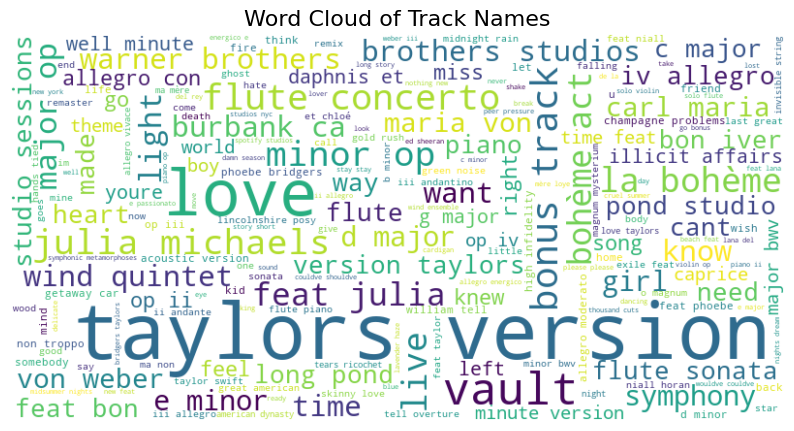

In [573]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['processed_track_name']))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Track Names', fontsize=16)
plt.show()
